In [6]:
from utils.utils import *
from utils.Algorithms import *
from utils.GraphCreation import *
from utils.Metrics import *
import pandas as pd
np.random.seed(0)

The following cell is used to run all our algorithms on a multi-layer graph, for the 3 different metric presented in the report.

In [7]:
def runResults(matrix, trueclusters, k, algorithms, metrics, mu_seq_SCSR):

    """
    Runs the algorithms and returns a dataframe with the results on the metrics
    
    Parameters
    ----------
    
    matrix (numpy.ndarray) Adjacency matrix of the graph
    true_clusters (list) List of the true clusters
    k (int) Number of target clusters
    algorithms (list) List of algorithms to run
    metrics (list) List of metrics to use

    Returns
    -------
    results (pandas.DataFrame) Dataframe with the results
    """

    results = pd.DataFrame(columns = ['Algorithm'] + [metric.__name__ for metric in metrics]+ ["Run Time"])

    for algorithm in algorithms:
        if algorithm.__name__ == 'SC_SR' or algorithm.__name__ == 'ourSC_SR':
            predictions, run_time = algorithm(matrix, k, true_clusters = trueclusters, mu_seq = mu_seq_SCSR)
            new_line = [algorithm.__name__] + [round(metric(predictions, trueclusters), 2) for metric in metrics] + [round(run_time, 2)]
            results.loc[len(results.index)] = new_line
        else:
            predictions, run_time = algorithm(matrix, k)
            new_line = [algorithm.__name__] + [round(metric(predictions, trueclusters), 2) for metric in metrics] + [round(run_time, 2)]
            results.loc[len(results.index)] = new_line

    results.set_index('Algorithm', inplace = True)

    return results

We define three probability of connections that we will widely use

In [8]:
HIGH = 0.8
MEDIUM = 0.5
LOW = 0.3

In this notebook, we will try to use extensively the algorithms, to uderstand how they perform on different situations. 
* Section 1 will be dedicated to a few simple examples to understand how the code work.
* Section 2 study how the algorithm behave when they face $M$ times the same layer, and when $M$ increases.
* Section 3 studies how the algorithm behave when the layers convey very different information
* Section 4 studies how the algorithm behaves when one or multiple layers are only made of noise.

# Section 1 - Simple examples

In this section, we show simple examples to understand how we will work.

We first show as example the adjecency matrix of a very simple graph, with two layers.

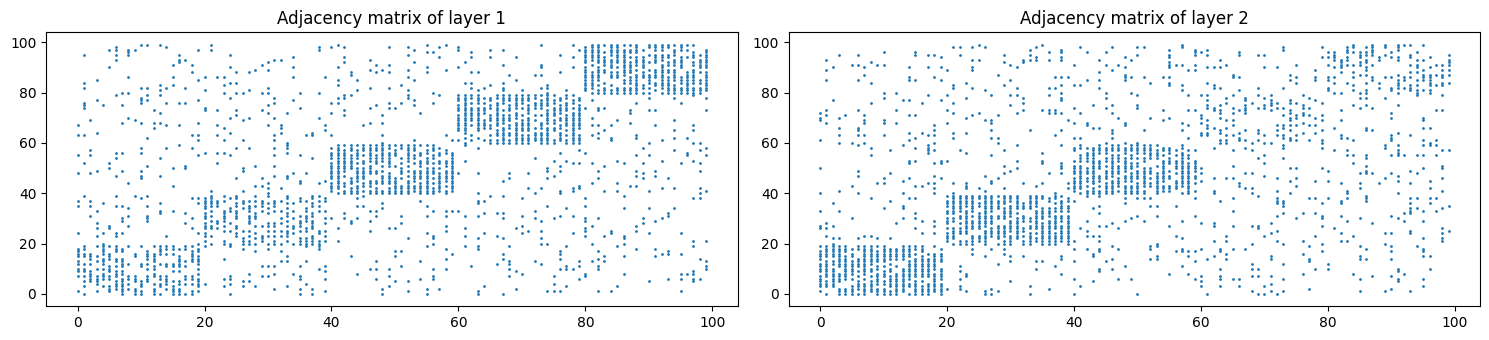

The results we obtain for this graph are : 


Purity  NMI   RI  Run Time
Algorithm                            
SC_GED        1.0  1.0  1.0      9.10
SC_SR         1.0  1.0  1.0      0.34
SC_SUM        1.0  1.0  1.0      0.00
SC_AL         1.0  1.0  1.0      0.18
ourSC_SR      1.0  1.0  1.0      0.27
CoR           1.0  1.0  1.0     39.37

In [9]:
n = 100 #number of points 
M = 2 #number of layers 
k = 5 #number of clusters 

p = HIGH
delta = 0.7 #should be between 0 and p

prob = np.full((k,M), p) #two people belonging to the same cluster are connected with probability p
prob[:2,0] = p -0.3 #in the first layer, two people belonging to cluster 0 or 1 are connected with probability p - 0.3
prob[3:,1] = p -0.5 #in the second layer, two people belonging to cluster 3 or 4 are connected with probability p - 0.5

prob_prime = np.full((k,k,M), p-delta) #two people that do not belong to the same cluster are connected with probability p - delta
clusters_size = k*[20]
algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, ourSC_SR, CoR] #list of algorithms we try
metrics = [Purity, NMI, RI] #list of metrics we use
matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = True)
results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR= [2])

print("The results we obtain for this graph are : ")
results

The previous graph is very simple, and we can clearly identify all the clusthers. All the algorithms recover almost perfectly the clusters. We can now try another graph, with 3 layers, and for which it is slightly harder to identify the clusters.

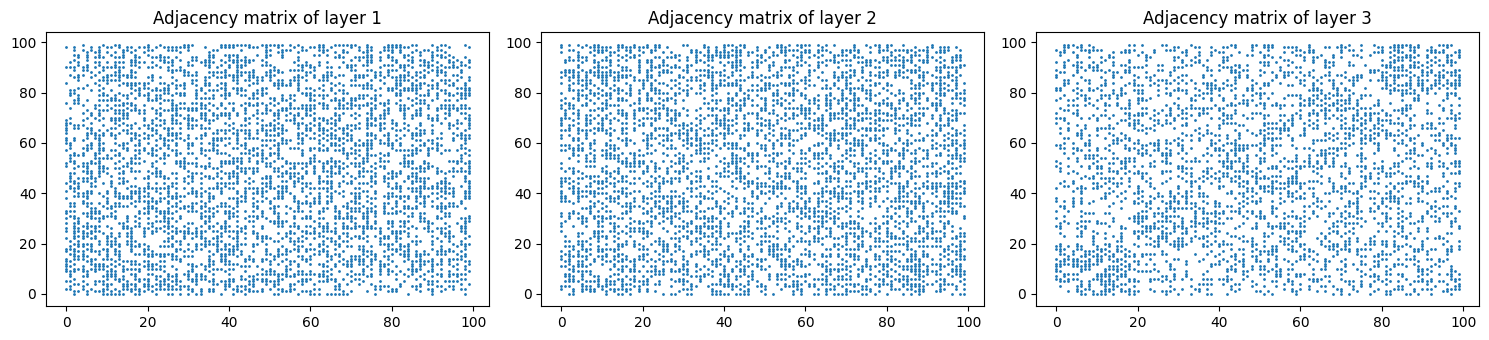

The results for this graph are : 


Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.31  0.05  0.68     20.70
SC_SR        0.45  0.22  0.73      1.42
SC_SUM       0.39  0.18  0.64      0.00
SC_AL        0.39  0.15  0.71      0.30
ourSC_SR     0.45  0.22  0.73      1.17
CoR          0.29  0.04  0.68     47.62

In [10]:
n = 100
M = 3 #three layers
k = 5

p = MEDIUM

prob = np.full((k,M),p) #people belonging to the same cluster are connected with probability p


prob_prime1 = np.full((k,k),p - 0.1) #in the first layer, people that do not belong to the same cluster are connected with probability p - 0.1
prob_prime2 = np.full((k,k),p - 0.1) #in the second layer, people that do not belong to the same cluster are connected with probability p - 0.1
prob_prime3 = np.full((k,k),p - 0.2) #in the third layer, people that do not belong to the same cluster are connected with probability p - 0.2

prob_prime = np.stack((prob_prime1,prob_prime2,prob_prime3),axis=2)
clusters_size = k*[20]

matrix,index_cluster = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = True)

results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR= [2, 1])
print("The results for this graph are : ")
results

The algorithms have more difficulties to recover the clusters. We can give a last example, where each layers conveys information very differently : the first layers gives information only about the two first clusters, the second layers about clusters 2 and 3, and the last layer about the last cluster.

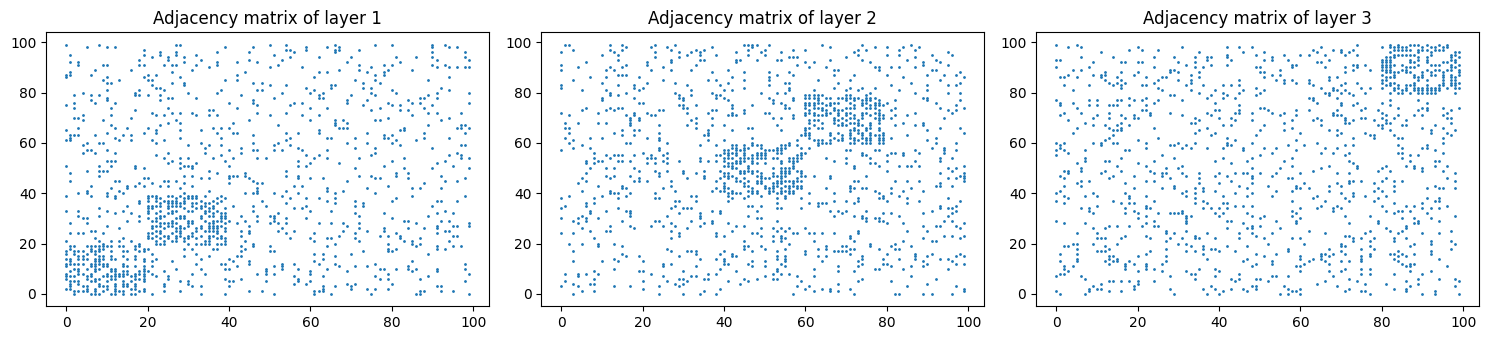

The results are : 


Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.47  0.22  0.73     22.11
SC_SR        0.50  0.28  0.75      2.69
SC_SUM       0.67  0.55  0.79      0.00
SC_AL        0.46  0.23  0.71      0.36
ourSC_SR     0.50  0.28  0.75      0.66
CoR          0.55  0.39  0.77     32.25

In [13]:
n = 100
M = 3
k = 5

p = MEDIUM

prob = np.full((k,M),p)
prob[:,0] = np.array([p, p, 0.1, 0.1, 0.1]) #first layer conveys information about clusters 0 and 1 
prob[:,1] = np.array([0.1, 0.1, p, p, 0.1]) #second layer conveys information about clusters 2 and 3 
prob[:,2] = np.array([0.1, 0.1, 0.1, 0.1, p]) #third layer conveys information about clusters 4


prob_prime1 = np.full((k,k),0.1) 
prob_prime2 = np.full((k,k),0.1)
prob_prime3 = np.full((k,k),0.1)

prob_prime = np.stack((prob_prime1,prob_prime2,prob_prime3),axis=2) #shape k,k,M
clusters_size = k*[20]

matrix,index_cluster = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = True)

results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR= [2, 1])
print("The results are : ")
results

# Section 2 - M times the "same" layer

We want here to study the asymptotic behaviour of our different algorithms when $M \rightarrow \infty$ at $\delta$ fixed ; and conversely, at M fixed, the asymptotic behaviour when $\delta \rightarrow 0$. Each layer is generated with the same parameter: each layer conveys the same type of information.

### Fine-tuning of the parameter $\mu = 1/ \lambda$ in SC-SR

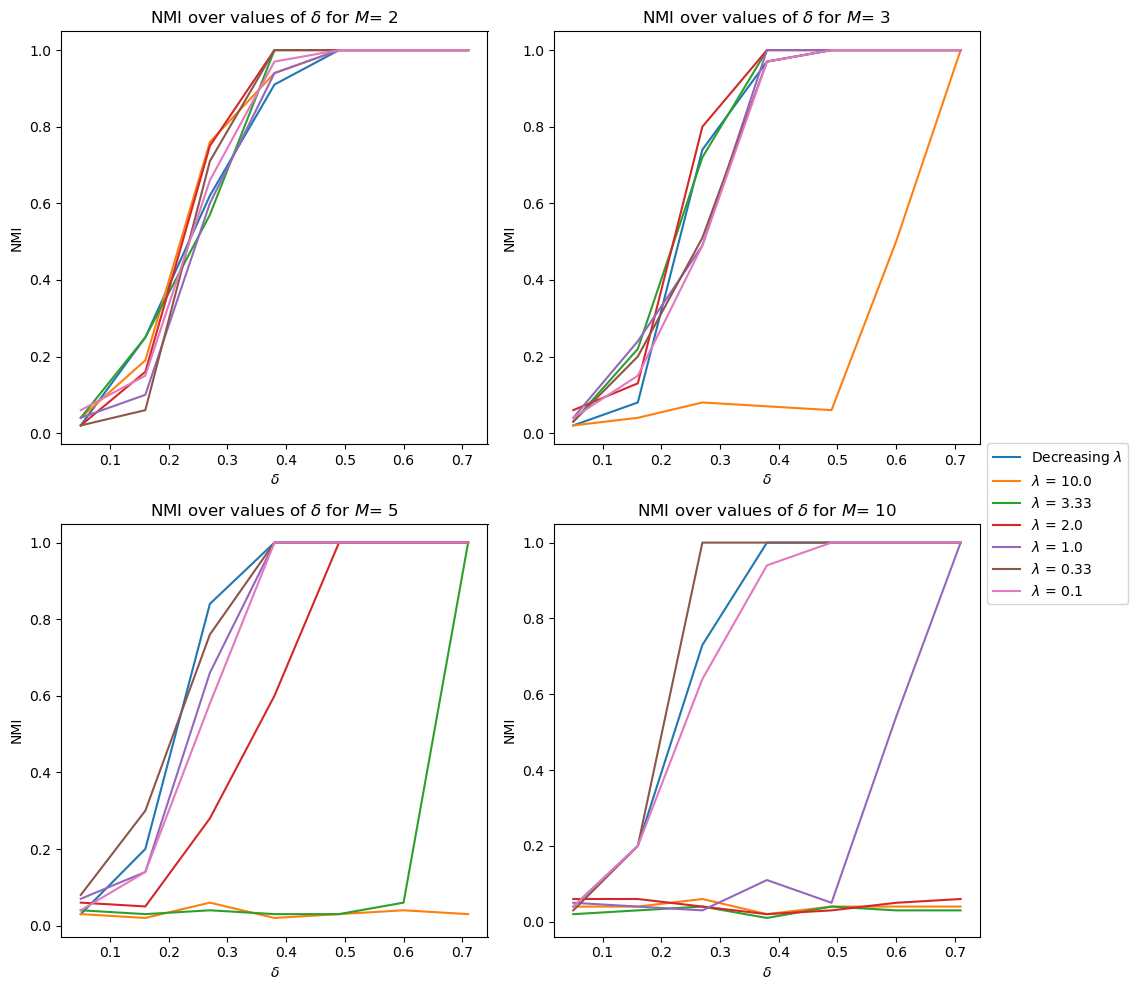

In [30]:
p = HIGH
n = 100
k = 4

mus = [0.1, 0.3, 0.5, 1, 3, 10]
deltas = np.arange(0.05, p, 0.11)
Ms = [2, 3, 5, 10]

all_res = {}
plt.subplots(figsize = (10, 10))
for idx, M in enumerate(Ms):
    plt.subplot(2, 2, Ms.index(M)+1)
    res= []
    for delta in deltas:
        prob = np.full((k,M), p)
        prob_prime = np.full((k,k,M), p-delta)
        clusters_size = k*[n //k]

        matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
        predictions, run_time = ourSC_SR(matrix, k, true_clusters = true_clusters, mu_seq = np.arange(1, M))
        
        res.append(round(NMI(predictions, true_clusters), 2))

    plt.plot(deltas, res, label = r"Decreasing $\lambda$")


    for mu in mus:
        res = []
        mu_seq_SCSR = mu*np.ones(M-1)
        for delta in deltas:
            prob = np.full((k,M), p)
            prob_prime = np.full((k,k,M), p-delta)
            clusters_size = k*[n //k]

            matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
            predictions, run_time = ourSC_SR(matrix, k, true_clusters = true_clusters, mu_seq = mu_seq_SCSR)
            
            res.append(round(NMI(predictions, true_clusters), 2))

        plt.plot(deltas, res, label = r'$\lambda$ = {}'.format(round(1/mu, 2)))

    plt.title(r'NMI over values of $\delta$ for $M$= {}'.format(M))
    plt.xlabel(r'$\delta$')
    plt.ylabel('NMI')

plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()

    
    


## Benchmark

In [31]:
n = 100
p = HIGH
k = 4


algorithms = [SC_GED , ourSC_SR, CoR, SC_SUM, SC_AL]
metrics = [Purity, NMI, RI]

Ms = [2, 3, 5, 10]
deltas = np.arange(0.05, p, 0.11)
all_res = {}

for M in Ms:
    for delta in deltas:
        prob = np.full((k,M), p)
        prob_prime = np.full((k,k,M), p-delta)
        clusters_size = k*[n //k]

        matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
        results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = 3*np.ones(M-1))
        print("M = ", M, "delta = ", delta)
        print(results)
        print("\n")
        all_res[M, delta] = results



M =  2 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.38  0.07  0.64      1.12
ourSC_SR     0.34  0.04  0.62      0.08
CoR          0.35  0.04  0.63      6.55
SC_SUM       0.35  0.05  0.63      0.00
SC_AL        0.38  0.06  0.64      0.03


M =  2 delta =  0.16
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.39  0.08  0.64      0.98
ourSC_SR     0.41  0.11  0.65      0.08
CoR          0.29  0.01  0.62      5.91
SC_SUM       0.41  0.11  0.60      0.00
SC_AL        0.44  0.12  0.66      0.03


M =  2 delta =  0.27
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.92  0.78  0.92      0.92
ourSC_SR     0.91  0.76  0.91      0.07
CoR          0.69  0.49  0.80      5.98
SC_SUM       0.92  0.80  0.93      0.00
SC_AL        0.99  0.97  0.99      0.02


M =  2 delta =  0.38
           Purity   NMI    RI  Run Time
Algorithm                     

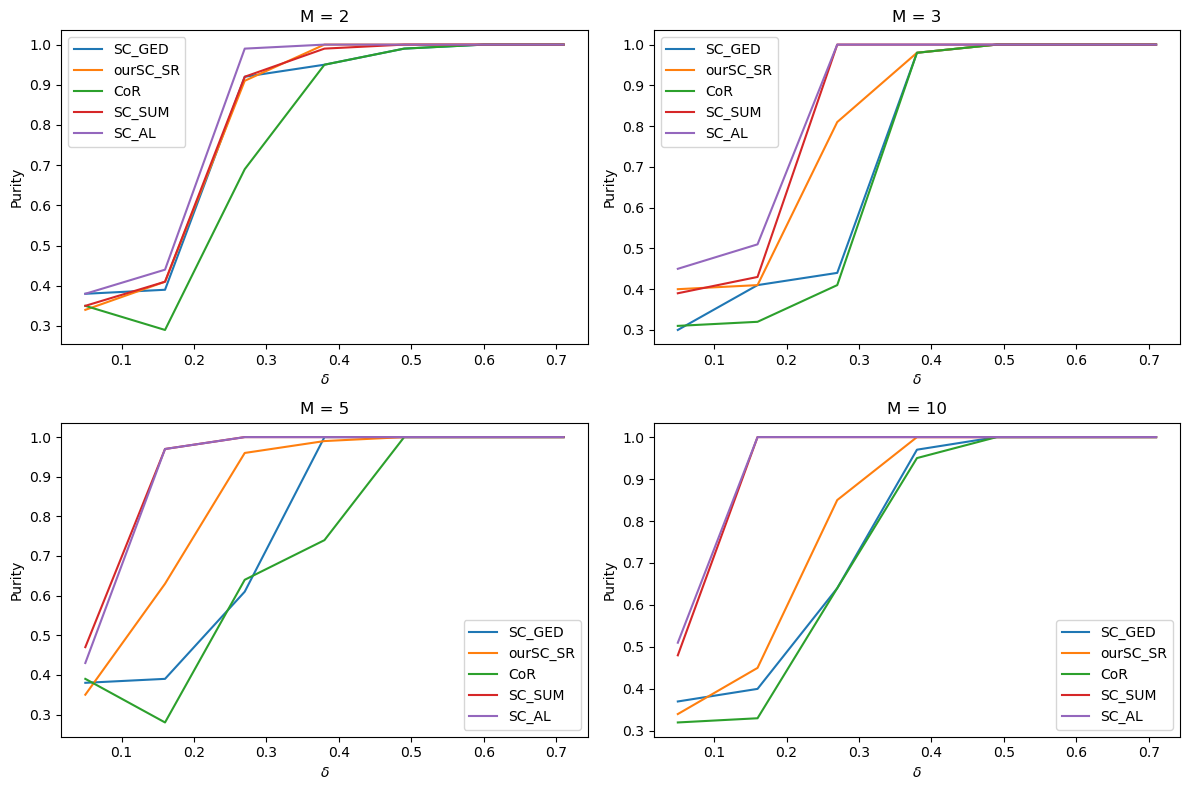

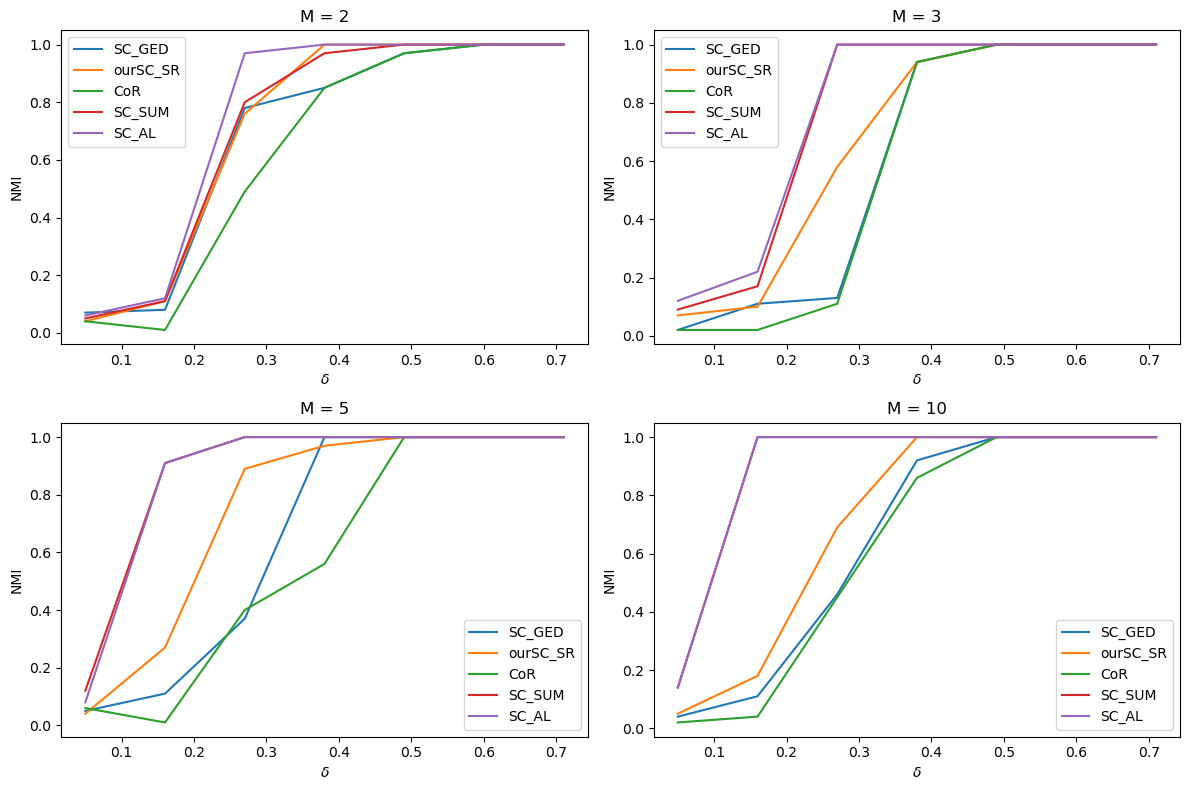

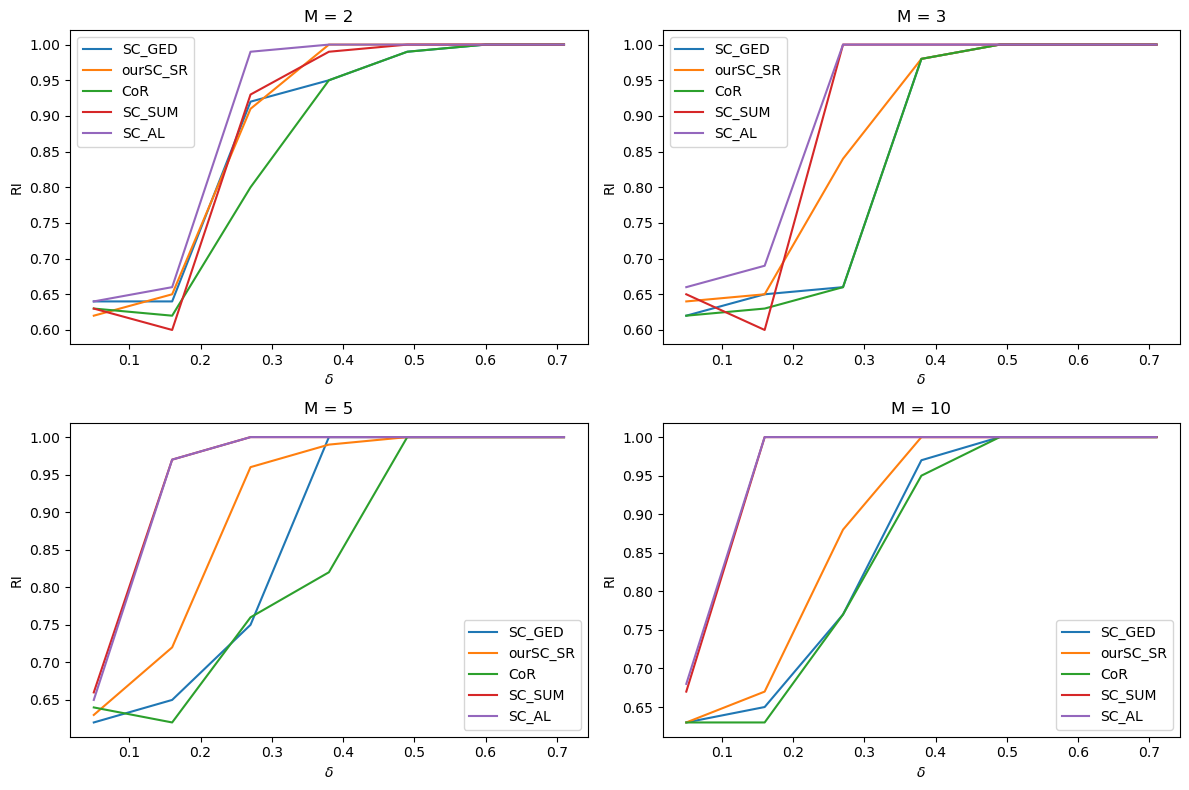

In [32]:
for metric in metrics:   
    plt.figure(figsize = (12, 8))
    for i, M in enumerate(Ms):
        plt.subplot(2, 2, i+1)
        for algorithm in algorithms:
            data = [all_res[M, delta][metric.__name__].loc[algorithm.__name__] for delta in deltas]
            plt.plot(deltas, data, label = algorithm.__name__)

        plt.title("M = " + str(M))
        plt.xlabel(r"$\delta$")
        plt.ylabel(metric.__name__)
        plt.legend()

    plt.tight_layout()
    plt.show()


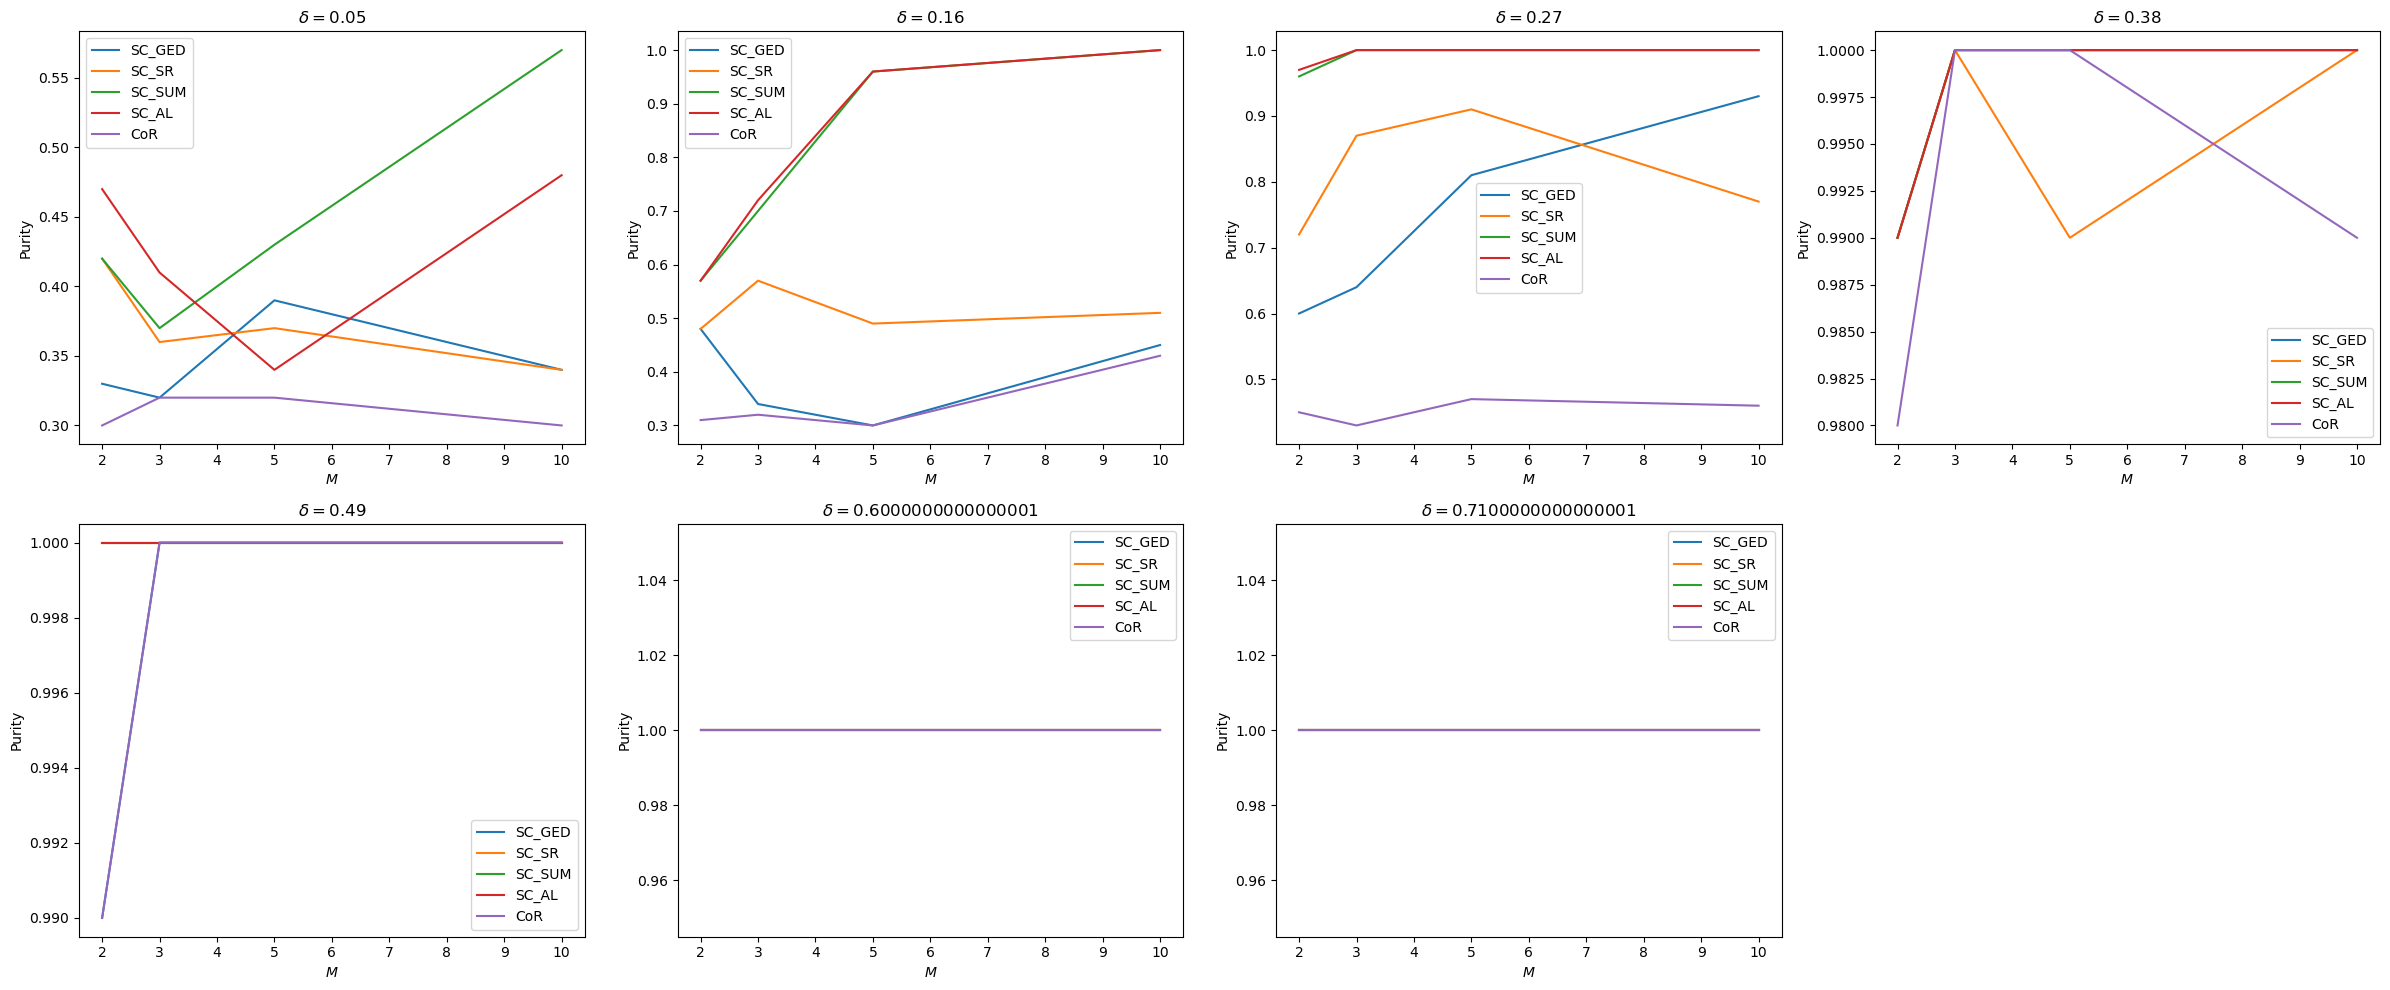

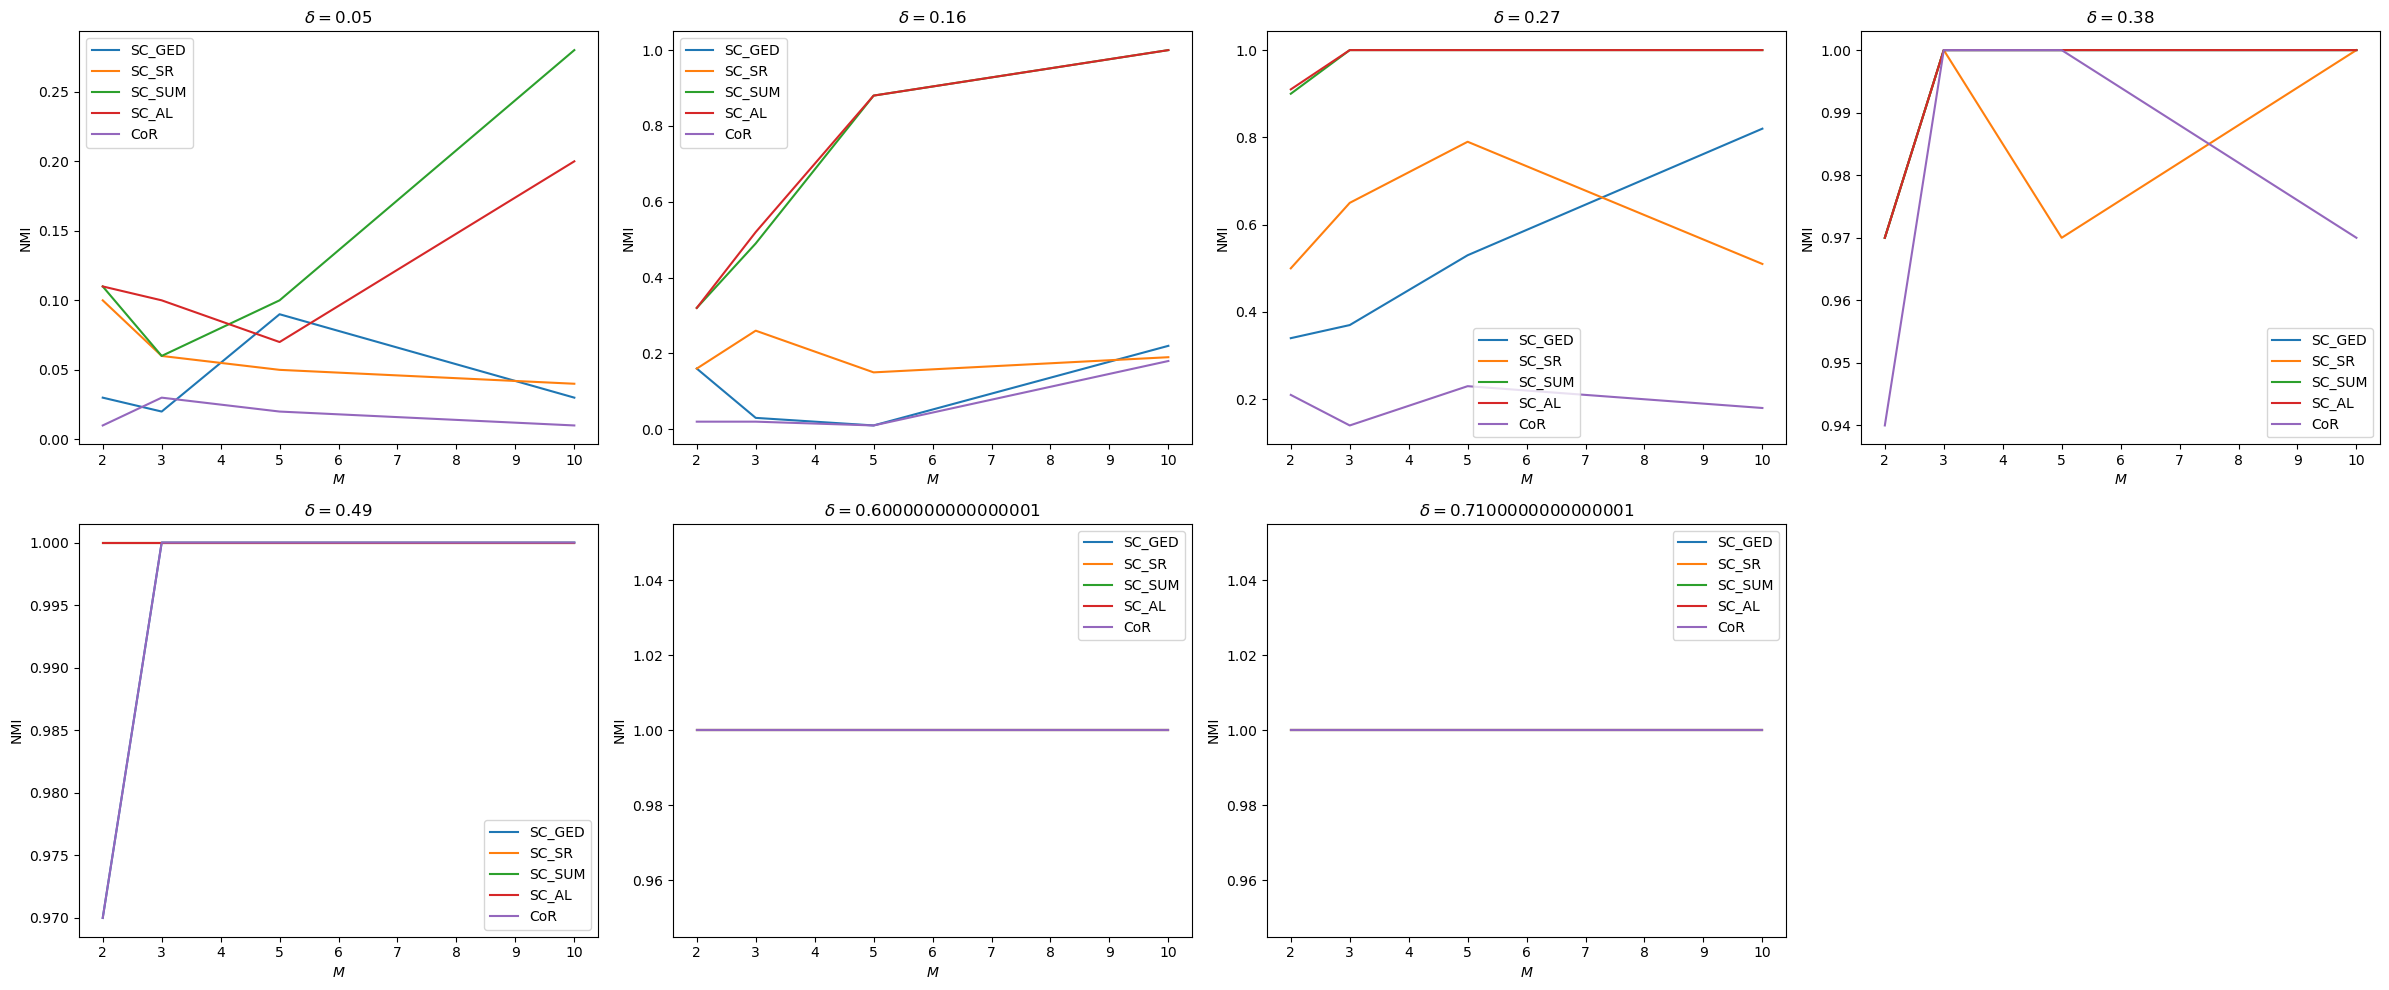

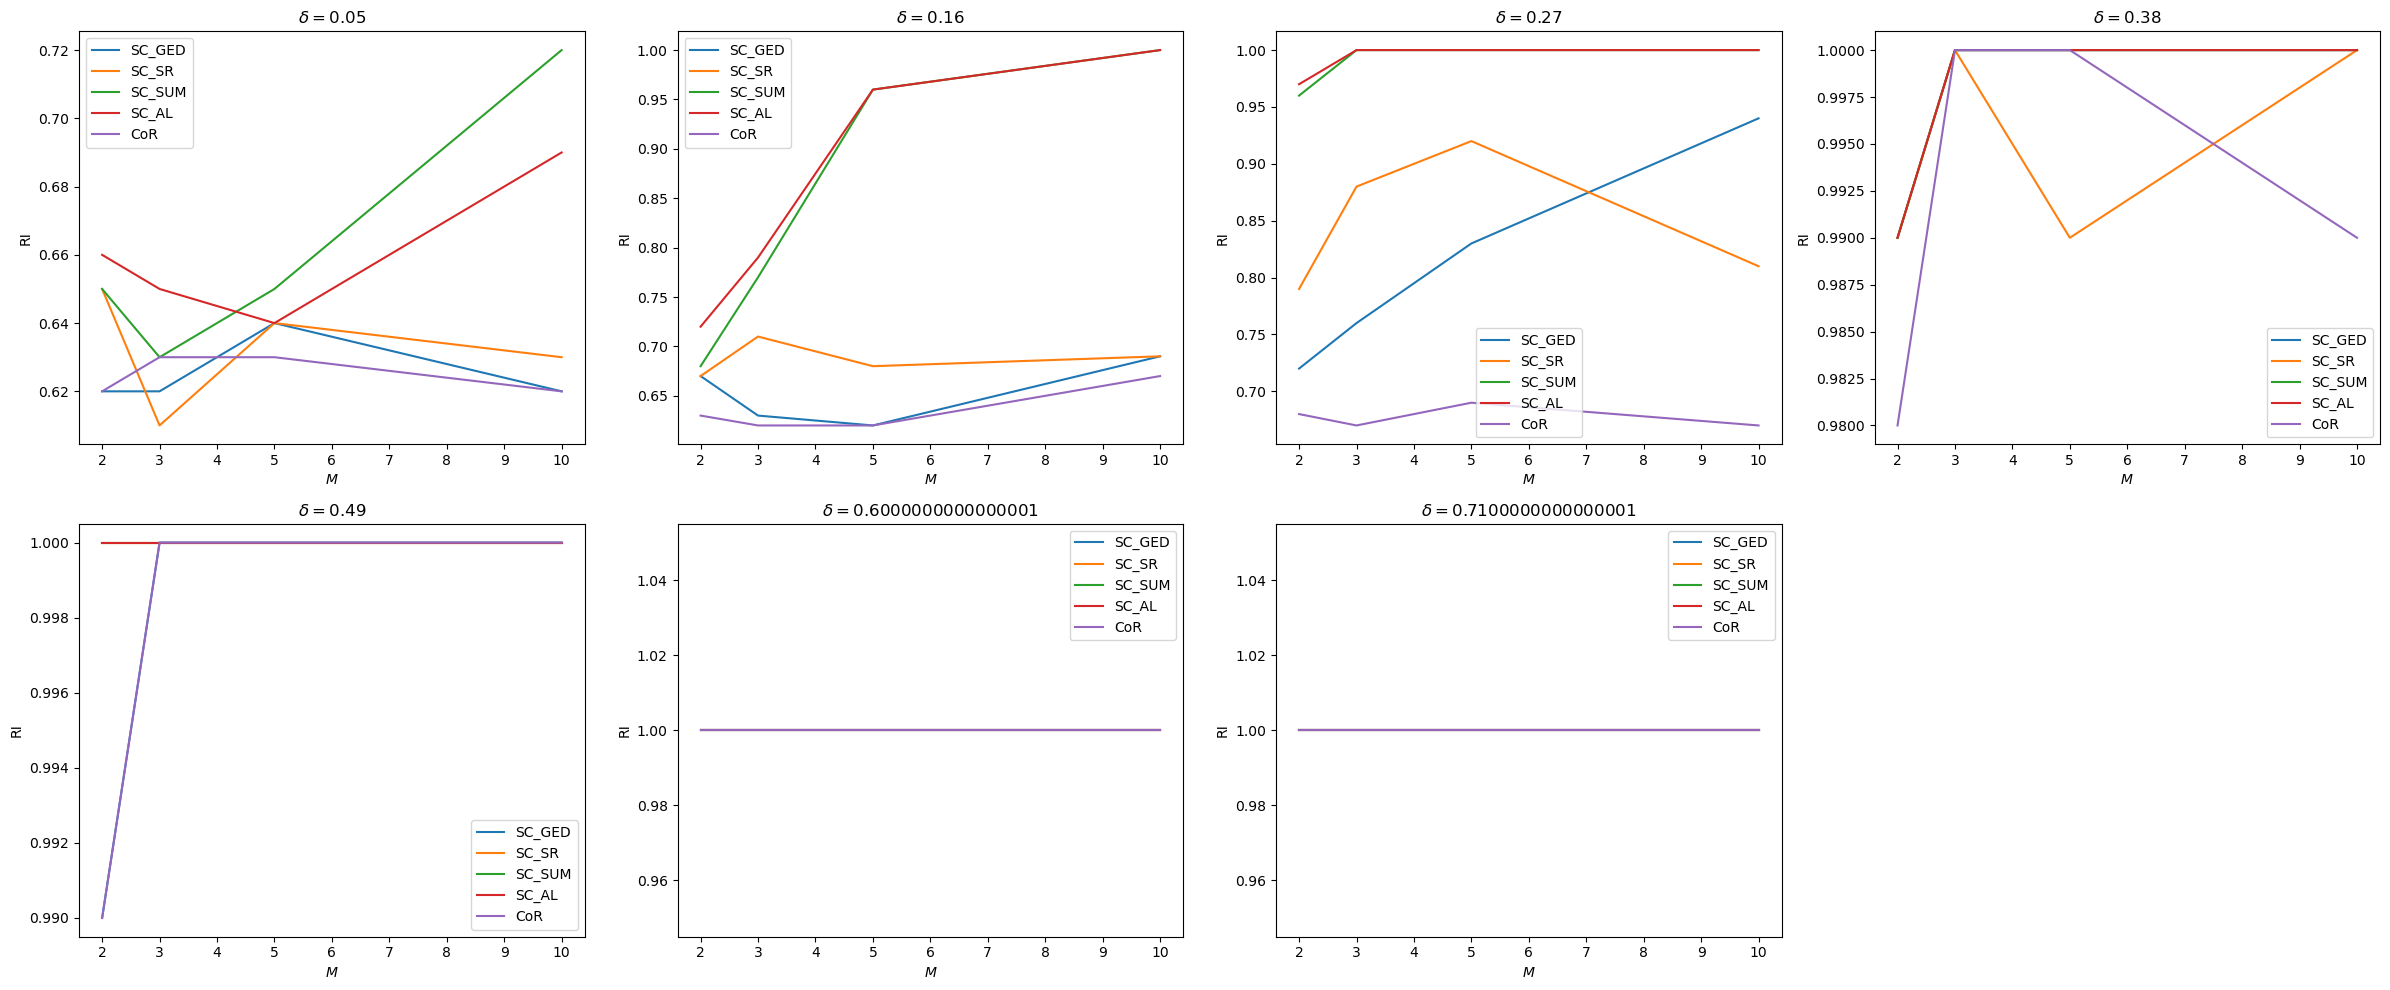

In [41]:
for metric in metrics:   
    plt.figure(figsize = (24, 10))
    for i in range(len(deltas)):
        plt.subplot(2, 4, i+1)
        delta = deltas[i]
        for algorithm in algorithms:
            data = [all_res[M, delta][metric.__name__].loc[algorithm.__name__] for M in Ms]
            plt.plot(Ms, data, label = algorithm.__name__)

        plt.title(r"$\delta = $" + str(delta))
        plt.xlabel(r"$M$")
        plt.ylabel(metric.__name__)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Section 3 - Information conveyed differently according to the layer

In this section, the layers are going to convey information in a very different way.

We take as example a graph with very different layers, and try different sequences of $\mu$, to find one that seems to work quite well. We take as example a graph of 5 layers, where each layer $i$ allows to identify cluster $i$, but nothing else. We try this both for SC_SR and ourSC_SR.

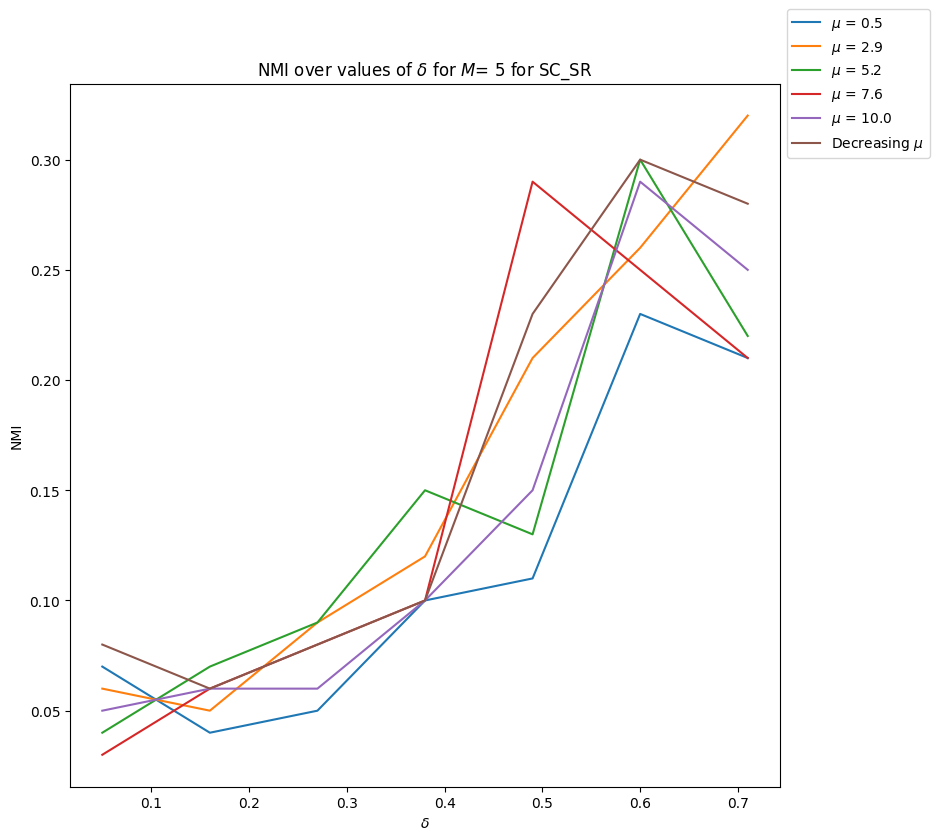

In [15]:
p = HIGH
n = 100
k = 5
M = 5

mus = np.linspace(0.5, 10, 5)
deltas = np.arange(0.05, p, 0.11)
all_res = {}
plt.subplots(figsize = (8, 8))


for mu in mus:
    res = []
    mu_seq_SCSR = mu*np.ones(M-1)
    for delta in deltas:
        prob = np.full((k,M), p-delta)
        for i in range(k):
            prob[i,i] = p 
        prob_prime = np.full((k,k,M), p-delta)
        clusters_size = k*[n //k]

        matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
        predictions, run_time = SC_SR(matrix, k, true_clusters = true_clusters, mu_seq = mu_seq_SCSR)
        
        res.append(round(NMI(predictions, true_clusters), 2))

    plt.plot(deltas, res, label = r'$\mu$ = {}'.format(round(mu, 1)))

res = []
for delta in deltas:
    prob = np.full((k,M), p-delta)
    for i in range(k):
        prob[i,i] = p 
    prob_prime = np.full((k,k,M), p-delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    predictions, run_time = SC_SR(matrix, k, true_clusters = true_clusters, mu_seq = np.sort(np.arange(1, M))[::-1])
    
    res.append(round(NMI(predictions, true_clusters), 2))

plt.plot(deltas, res, label = r'Decreasing $\mu$')
plt.title(r'NMI over values of $\delta$ for $M$= {} for SC_SR'.format(M))
plt.xlabel(r'$\delta$')

plt.ylabel('NMI')

plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()


All the values seem to have more or less the same behaviour. We take constant $\mu = 2.9$, which seems to have slightly less variance. 

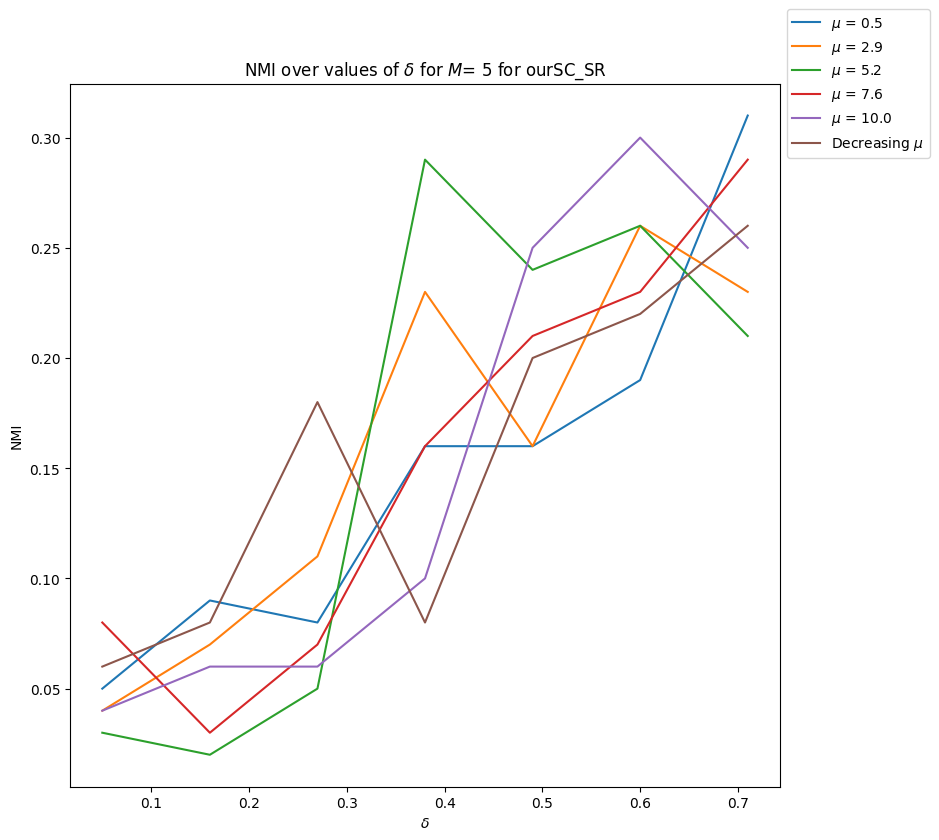

In [17]:
p = HIGH
n = 100
k = 5
M = 5

mus = np.linspace(0.5, 10, 5)
deltas = np.arange(0.05, p, 0.11)
all_res = {}
plt.subplots(figsize = (8, 8))


for mu in mus:
    res = []
    mu_seq_SCSR = mu*np.ones(M-1)
    for delta in deltas:
        prob = np.full((k,M), p-delta)
        for i in range(k):
            prob[i,i] = p 
        prob_prime = np.full((k,k,M), p-delta)
        clusters_size = k*[n //k]

        matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
        predictions, run_time = ourSC_SR(matrix, k, true_clusters = true_clusters, mu_seq = mu_seq_SCSR)
        
        res.append(round(NMI(predictions, true_clusters), 2))

    plt.plot(deltas, res, label = r'$\mu$ = {}'.format(round(mu, 1)))

res = []
for delta in deltas:
    prob = np.full((k,M), p-delta)
    for i in range(k):
        prob[i,i] = p 
    prob_prime = np.full((k,k,M), p-delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    predictions, run_time = ourSC_SR(matrix, k, true_clusters = true_clusters, mu_seq = np.sort(np.arange(1, M))[::-1])
    
    res.append(round(NMI(predictions, true_clusters), 2))

plt.plot(deltas, res, label = r'Decreasing $\mu$')
plt.title(r'NMI over values of $\delta$ for $M$= {} for ourSC_SR'.format(M))
plt.xlabel(r'$\delta$')

plt.ylabel('NMI')

plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()


Keeping the same sequence with $\mu = 2.9$ seems relevant

In [4]:
mu = 2.9

## Experiments

For this experiment, each layer $i$ conveys information only about cluster $i$. In layer $i$, two people belonging to cluster $i$ are connected with probability $p$. If the two people are not in cluster $i$, they are connnected with probability $p - \delta$. We try different values of $\delta$.

In [21]:
n = 100
p = HIGH
k = 5
M = 5


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR, ourSC_SR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.05, p, 0.11)
all_res = {}

for delta in deltas:
    print("Next iteration, delta = ",delta)
    prob = np.full((k,M), p-delta)
    for i in range(k):
        prob[i,i] = p
    prob_prime = np.full((k,k,M), p-delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)
    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results

Next iteration, delta =  0.05
M =  5 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.31  0.07  0.68     16.84
SC_SR        0.31  0.04  0.68      4.37
SC_SUM       0.35  0.09  0.69      0.00
SC_AL        0.33  0.06  0.68      0.53
CoR          0.33  0.05  0.69     40.78
ourSC_SR     0.32  0.04  0.69      1.96


Next iteration, delta =  0.16
M =  5 delta =  0.16
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.34  0.10  0.69     18.14
SC_SR        0.35  0.06  0.69      3.33
SC_SUM       0.30  0.04  0.67      0.00
SC_AL        0.30  0.04  0.68      0.44
CoR          0.33  0.06  0.69     46.70
ourSC_SR     0.35  0.06  0.69      1.91


Next iteration, delta =  0.27
M =  5 delta =  0.27
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.32  0.06  0.69     29.90
SC_SR        0.33  0.07  0.69      3.78
SC_SUM       0.36  0.10  0.69      0.00
SC_

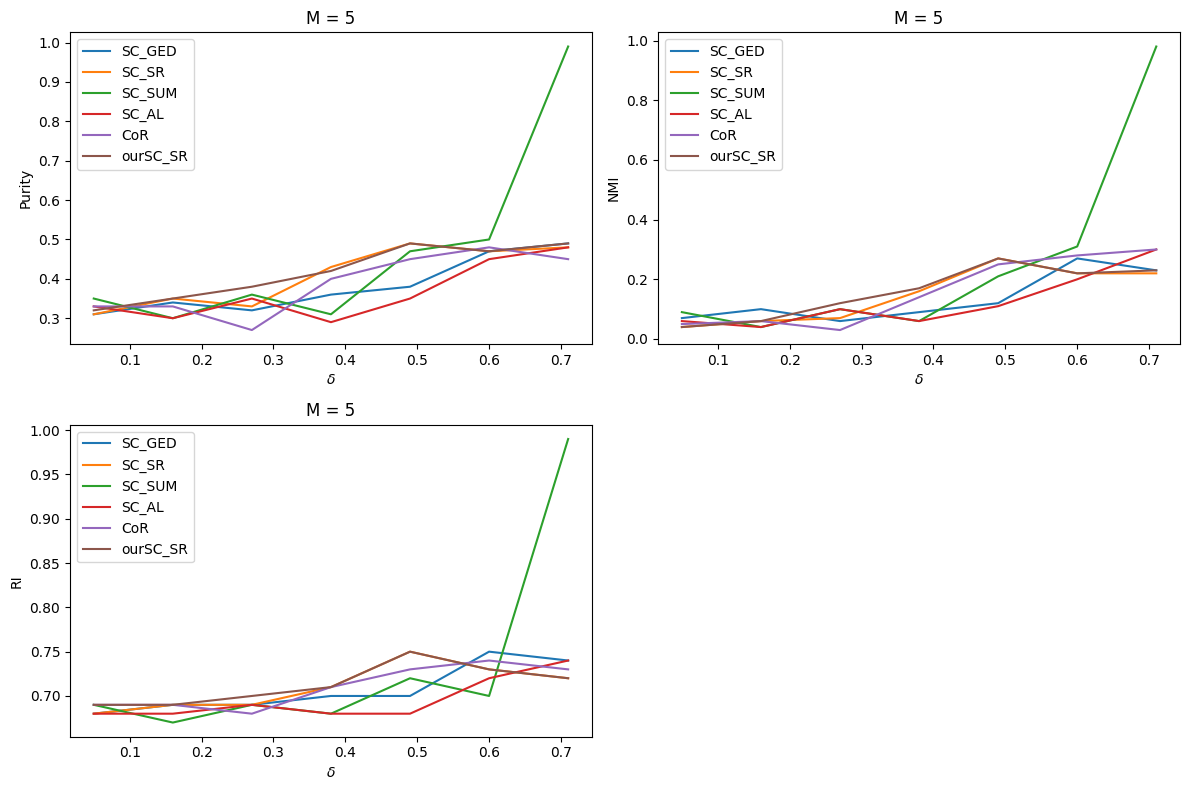

In [29]:
deltas = np.arange(0.05, p, 0.11)
i = 0
plt.figure(figsize = (12, 8))

for metric in metrics:   
    plt.subplot(2, 2, i+1)
    i += 1
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()


Until $\delta = 0.6$, all the algorithms behave the same way. After this point, SC_SUM is doing much better. 

We now try the same experiments, with $p$ MEDIUM instead of high

Next iteration, delta =  0.05


M =  5 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.32  0.07  0.69     22.05
SC_SR        0.29  0.03  0.68      1.21
SC_SUM       0.33  0.06  0.68      0.00
SC_AL        0.38  0.10  0.70      0.22
CoR          0.35  0.09  0.69     33.29
ourSC_SR     0.28  0.03  0.68      1.45


Next iteration, delta =  0.1
M =  5 delta =  0.1
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.30  0.04  0.68     31.27
SC_SR        0.32  0.06  0.69      3.32
SC_SUM       0.28  0.03  0.67      0.00
SC_AL        0.30  0.04  0.68      0.37
CoR          0.29  0.04  0.68     53.89
ourSC_SR     0.32  0.06  0.69      2.24


Next iteration, delta =  0.15000000000000002
M =  5 delta =  0.15000000000000002
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.26  0.02  0.68     34.48
SC_SR        0.30  0.07  0.69      4.78
SC_SUM       0.33  0.11  0.69      0.00
SC_AL

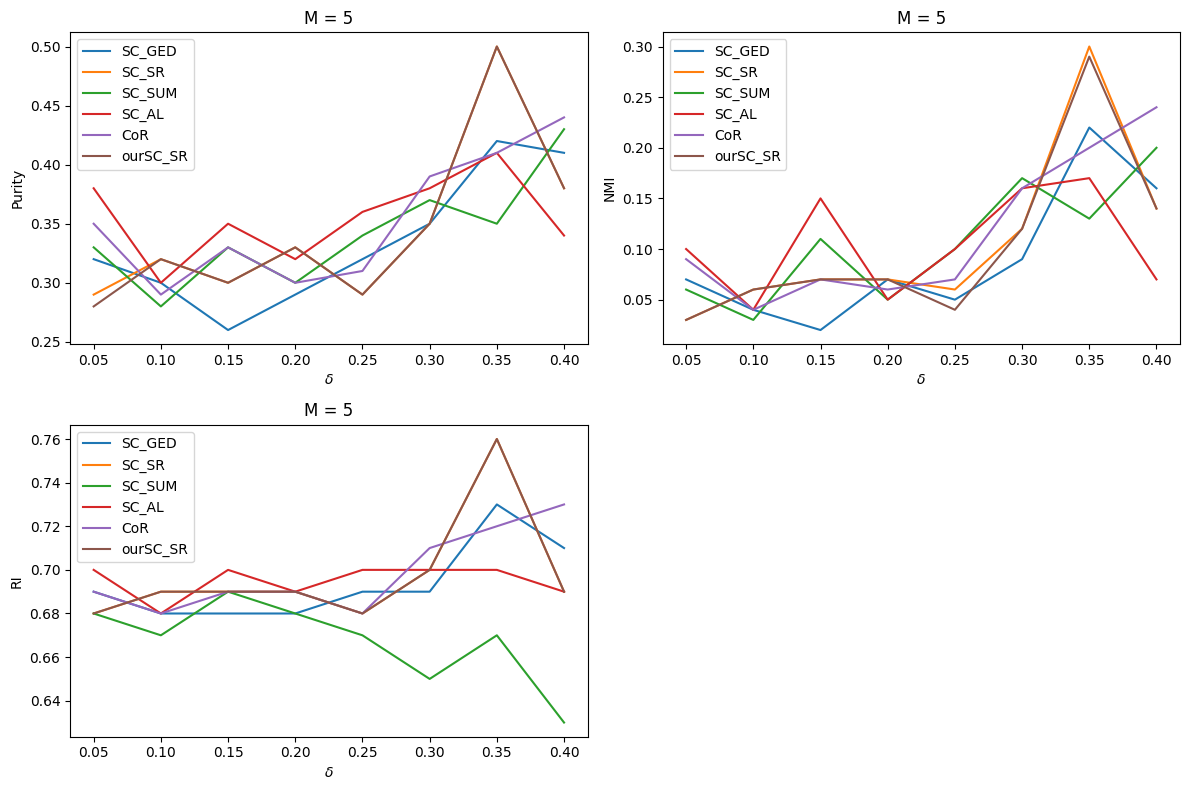

In [32]:
n = 100
p = MEDIUM
k = 5
M = 5


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR,ourSC_SR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.05, 0.41, 0.05)
all_res = {}

for delta in deltas:
    print("Next iteration, delta = ",delta)
    prob = np.full((k,M), p-delta)
    for i in range(k):
        prob[i,i] = p
    prob_prime = np.full((k,k,M), p-delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)
    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results

i = 0
plt.figure(figsize = (12, 8))

for metric in metrics:   
    plt.subplot(2, 2, i+1)
    i += 1
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()

We see that when $p$ is reduced to MEDIUM, instead of HIGH, SC_SR shows equal or better performance than SC_SUM. However, it is not possible to find a reald trend. 

We reproduce the same experiments than before, but with $M = 3$ layers only. Layer $1$ conveys information about cluster $0$ and $1$ only, layer $1$ about cluster $2$ and $3$, and layer $3$ about the last cluste.

In [34]:
n = 100
p = HIGH
k = 5
M = 3


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR,ourSC_SR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.05, p, 0.1)
all_res = {}

for delta in deltas:
    prob = np.full((k,M), p-delta)
    prob[:2,0] = p
    prob[2:4,1] = p
    prob[4,2] = p
    prob_prime = np.full((k,k,M), p-delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)
    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results

M =  3 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.35  0.07  0.69     10.95
SC_SR        0.31  0.06  0.68      1.20
SC_SUM       0.34  0.06  0.68      0.00
SC_AL        0.31  0.07  0.69      0.25
CoR          0.31  0.06  0.69     51.56
ourSC_SR     0.31  0.06  0.68      0.70


M =  3 delta =  0.15000000000000002
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.33  0.07  0.69     11.52
SC_SR        0.30  0.05  0.68      1.25
SC_SUM       0.34  0.09  0.67      0.00
SC_AL        0.39  0.09  0.70      0.28
CoR          0.29  0.03  0.68     58.55
ourSC_SR     0.30  0.05  0.68      0.59


M =  3 delta =  0.25000000000000006
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.32  0.09  0.69     12.12
SC_SR        0.35  0.08  0.69      1.82
SC_SUM       0.32  0.05  0.68      0.00
SC_AL        0.33  0.09  0.69      0.45
CoR          0.31  0.05

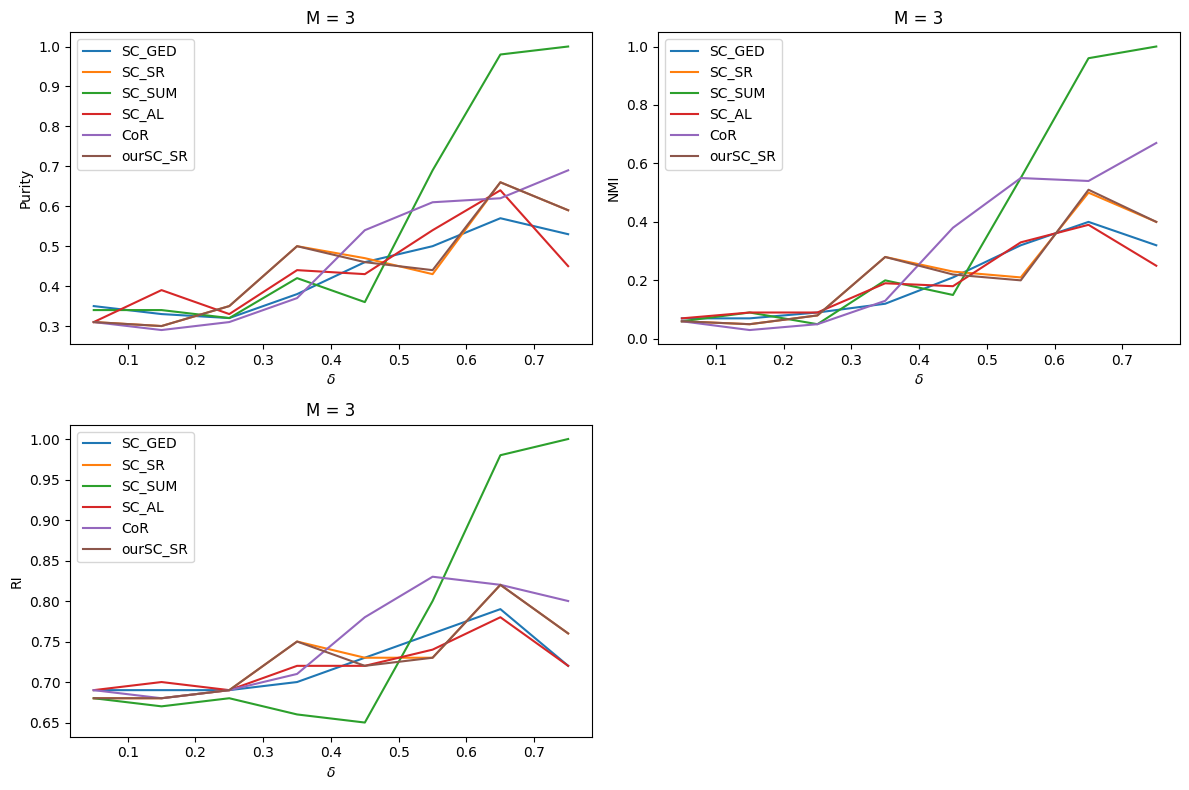

In [35]:
i = 0
plt.figure(figsize = (12, 8))

for metric in metrics:   
    plt.subplot(2, 2, i+1)
    i += 1
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()


There is small range for which SC_GED and SC_SR behave better than SC_SUM, but it is very thin. It is not possible to conclude that has SC_SR has competitive performance with this example.

We had also made experiments for $M =2$, but we did not include them, as we found results very similar to $M = 3$.

## Layers with different probas of being friends

We made experiments where in each layer, every cluster had the same probability of connection, but this probability was changing from one layer to another.  

M =  3 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.35  0.08  0.69     13.85
SC_SR        0.30  0.06  0.69      1.83
SC_SUM       0.47  0.21  0.71      0.00
SC_AL        0.42  0.14  0.70      0.40
CoR          0.27  0.05  0.68     68.33
ourSC_SR     0.30  0.06  0.69      1.51


M =  3 delta =  0.1
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.57  0.32  0.76     14.48
SC_SR        0.42  0.13  0.71      2.18
SC_SUM       0.76  0.57  0.84      0.00
SC_AL        0.76  0.53  0.84      0.28
CoR          0.33  0.07  0.69     60.09
ourSC_SR     0.42  0.13  0.71      2.25


M =  3 delta =  0.15000000000000002
           Purity  NMI   RI  Run Time
Algorithm                            
SC_GED        1.0  1.0  1.0     20.92
SC_SR         1.0  1.0  1.0      1.73
SC_SUM        1.0  1.0  1.0      0.00
SC_AL         1.0  1.0  1.0      0.22
CoR           1.0  1.0  1.0     61.45
ourSC_SR     

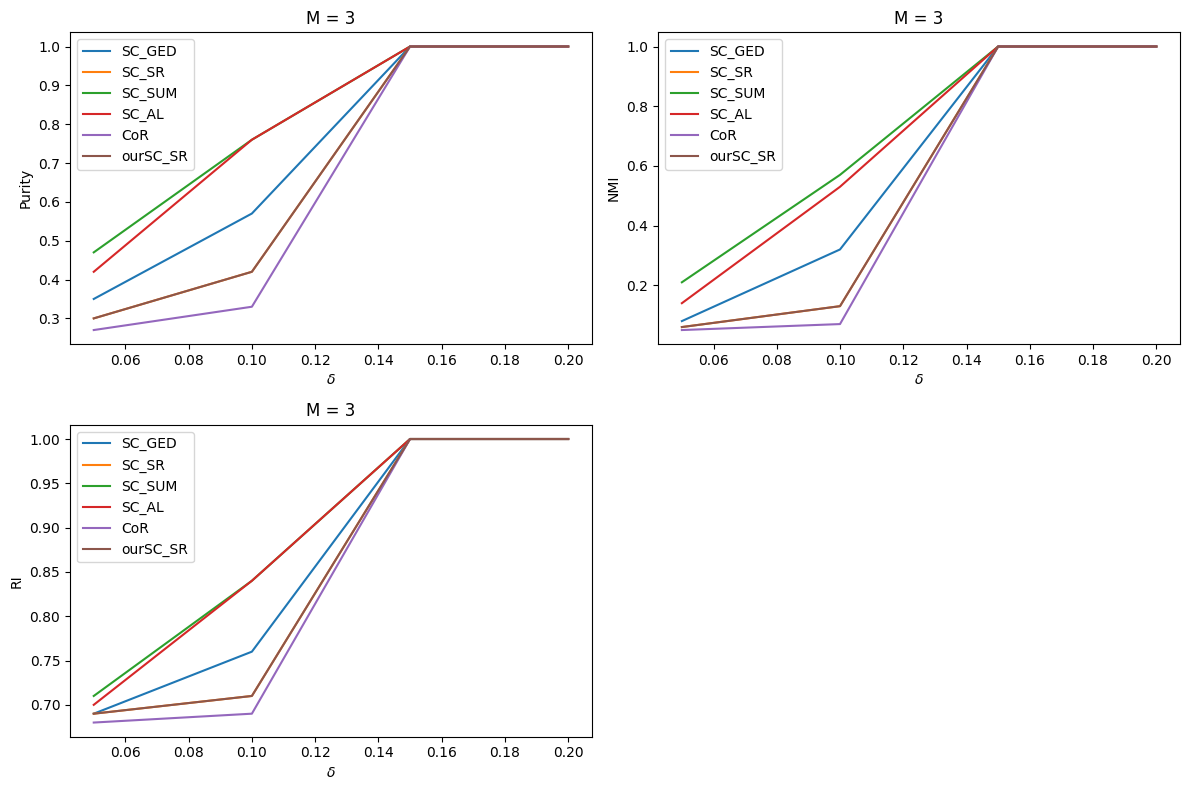

In [36]:
n = 100
p = HIGH
k = 5
M = 3


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR, ourSC_SR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.05, 0.25, 0.05)
all_res = {}

for delta in deltas:
    prob = np.full((k,M), p-delta)
    prob[:,0] = p 
    prob[:,1] = p - delta
    prob[:,2] = p -2* delta
    prob_prime = np.full((k,k,M), p-3*delta)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)
    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results


i = 0
plt.figure(figsize = (12, 8))

for metric in metrics:   
    plt.subplot(2, 2, i+1)
    i += 1
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()


Once again, SC_SR or SC_GED does not have better results than SC_SUM or SC_AL.

We test another example. The 4 first layers are defined with the same proabilities, the last one with another set of probability.

M =  5 delta =  0.02
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.29  0.04  0.68     29.14
SC_SR        0.49  0.27  0.74      3.00
SC_SUM       0.38  0.12  0.70      0.00
SC_AL        0.43  0.21  0.72      0.59
CoR          0.33  0.10  0.70     54.15
ourSC_SR     0.52  0.29  0.75      1.53


M =  5 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.29  0.04  0.67     34.74
SC_SR        0.62  0.37  0.78      2.24
SC_SUM       0.38  0.13  0.70      0.00
SC_AL        0.48  0.23  0.73      0.21
CoR          0.29  0.04  0.68     35.65
ourSC_SR     0.62  0.37  0.78      0.81


M =  5 delta =  0.08
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.27  0.04  0.67     27.31
SC_SR        0.44  0.21  0.72      2.04
SC_SUM       0.51  0.32  0.75      0.00
SC_AL        0.65  0.47  0.81      0.20
CoR          0.32  0.05  0.69     29.85
ourSC_SR     

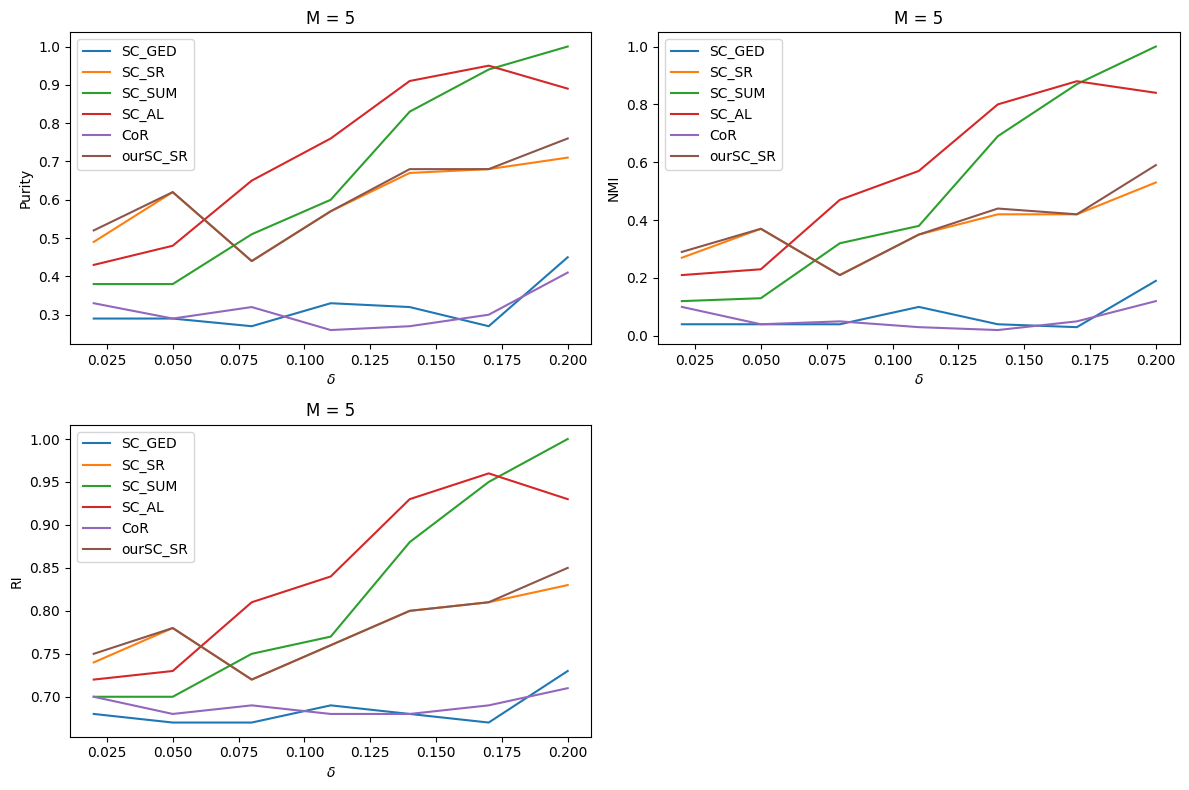

In [10]:
n = 100
p = HIGH
k = 5
M = 5


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR,ourSC_SR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.02, 0.2, 0.03)
all_res = {}

for delta in deltas:
    prob = np.full((k,M), p-delta)
    prob[:,0] = p - delta
    prob[:,1] = p - delta
    prob[:,2] = p - delta
    prob[:,3] = p - delta
    prob[:,4] = 0.3

    prob_prime = np.full((k,k,M), p-2*delta)
    prob_prime[:,:,M-1] = np.full((k,k),0.1)

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)

    clusters_size = k*[n //k]
    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)

    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results


i = 0
plt.figure(figsize = (12, 8))

for metric in metrics:   
    plt.subplot(2, 2, i+1)
    i += 1
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()


We can notice that there is a small range for which SC_SR is better. Intuitively, it seems expected : the other algorithm are in lot of point behaving like averages : they are not able to catch the specificities of the last layer. SC_SR, on the contrary, is able to do it.

M =  5 delta =  0.02
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.33  0.06  0.69     24.53
SC_SR        0.89  0.75  0.92      2.05
SC_SUM       0.46  0.20  0.71      0.00
SC_AL        0.64  0.46  0.80      0.14
CoR          0.30  0.04  0.68     43.66
ourSC_SR     0.89  0.75  0.92      0.74


M =  5 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.34  0.09  0.70     29.34
SC_SR        0.88  0.75  0.91      1.95
SC_SUM       0.55  0.28  0.74      0.00
SC_AL        0.82  0.67  0.88      0.15
CoR          0.32  0.06  0.69     45.06
ourSC_SR     0.88  0.75  0.91      1.05


M =  5 delta =  0.08
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.29  0.04  0.68     30.42
SC_SR        0.73  0.52  0.83      2.31
SC_SUM       0.53  0.30  0.76      0.00
SC_AL        0.83  0.63  0.88      0.54
CoR          0.35  0.07  0.69     43.24
ourSC_SR     

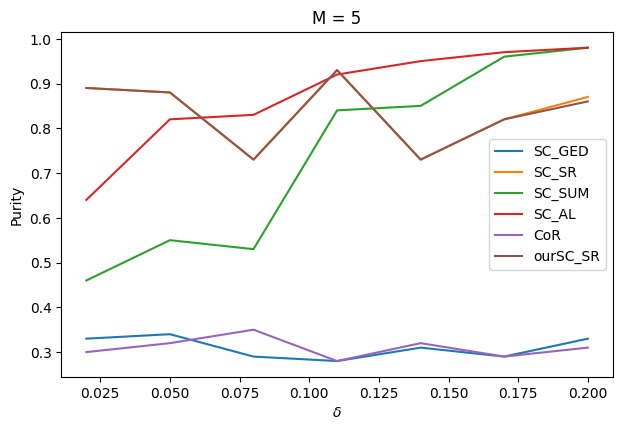

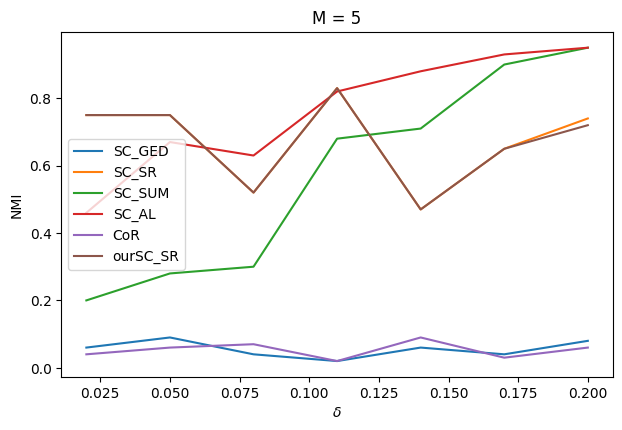

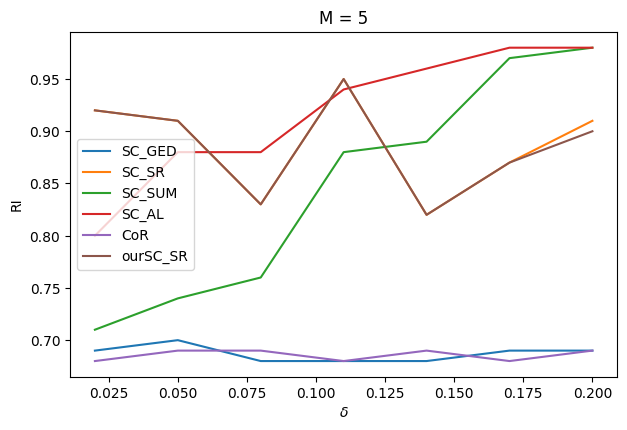

In [11]:
n = 100
p = HIGH
k = 5
M = 5


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR,ourSC_SR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.02, 0.2, 0.03)
all_res = {}

for delta in deltas:
    prob = np.full((k,M), p-delta)
    prob[:,0] = p - delta
    prob[:,1] = p - delta
    prob[:,2] = p - delta
    prob[:,3] = p - delta
    prob[:,4] = 0.5

    prob_prime = np.full((k,k,M), p-2*delta)
    prob_prime[:,:,M-1] = np.full((k,k),0.2)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)

    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)

    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results


i = 1
for metric in metrics:   
    plt.figure(figsize = (12, 8))
    plt.subplot(2, 2, i+1)
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

    plt.tight_layout()
    plt.show()

Once again, SC_SR is performing quite well, especially when $\delta$ is small. SC_SUM or SC_AL sometimes perform better, but SC_SR has a performance with less variance.

We try another example. On the first layer, the probabilities of connection are really high. They are medium on the second one and low on the last one. The gap between cluster connection and other connections remain the same.

M =  3 delta =  0.05
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.31  0.05  0.67     14.24
SC_SR        0.29  0.05  0.68      1.98
SC_SUM       0.42  0.13  0.71      0.00
SC_AL        0.28  0.04  0.66      0.28
CoR          0.29  0.08  0.69     45.93
ourSC_SR     0.29  0.05  0.68      0.67


M =  3 delta =  0.1
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.31  0.07  0.69     12.11
SC_SR        0.36  0.13  0.70      0.97
SC_SUM       0.32  0.09  0.55      0.00
SC_AL        0.38  0.10  0.70      0.16
CoR          0.27  0.03  0.68     38.76
ourSC_SR     0.36  0.13  0.70      0.51


M =  3 delta =  0.15000000000000002
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.33  0.09  0.69     14.80
SC_SR        0.43  0.20  0.71      1.35
SC_SUM       0.53  0.30  0.73      0.00
SC_AL        0.56  0.36  0.76      0.15
CoR          0.25  0.02  0.68     43.02

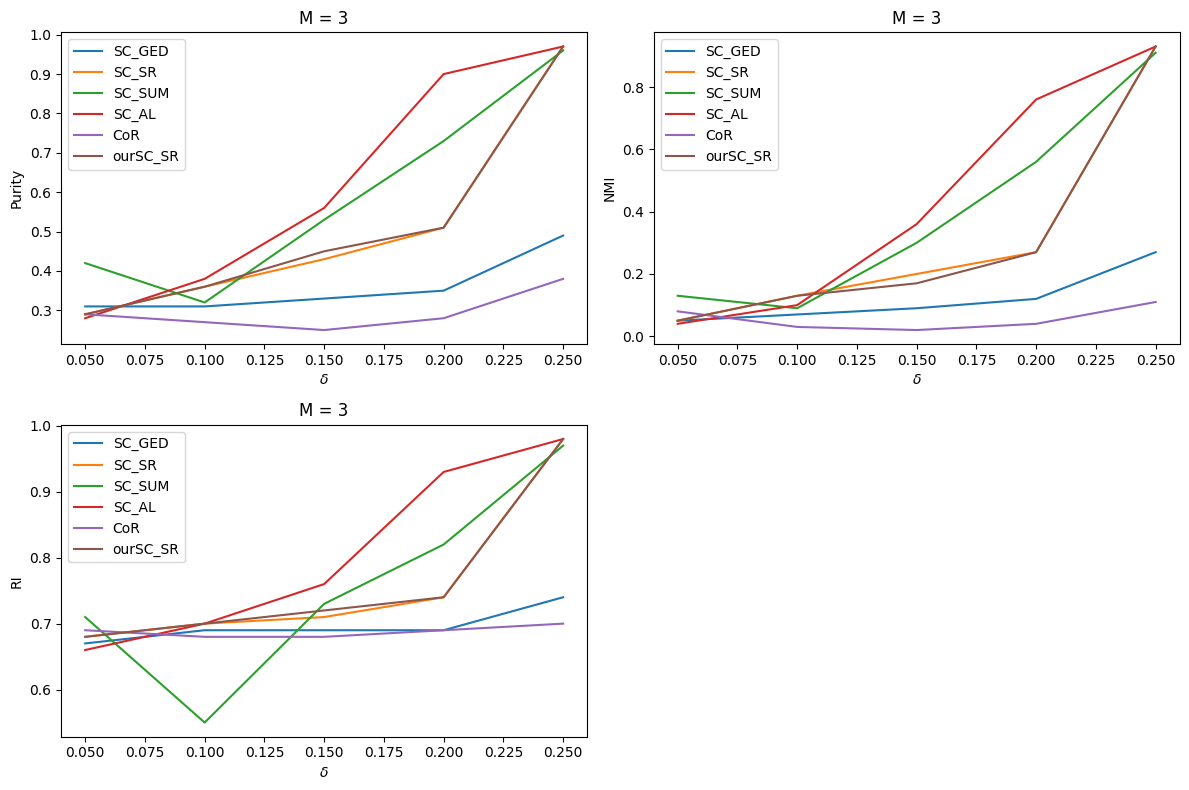

In [15]:
n = 100
p = HIGH
k = 5
M = 3


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR,ourSC_SR]
metrics = [Purity, NMI, RI]

deltas = np.arange(0.05, 0.3, 0.05)
all_res = {}

for delta in deltas:
    prob = np.full((k,M), p)
    prob[:,2] = LOW 
    prob[:,1] = MEDIUM
    prob[:,0] = HIGH
    prob_prime = np.full((k,k,M), p)
    prob_prime[:,:,2] = np.full((k,k), LOW - delta)
    prob_prime[:,:,1] = np.full((k,k), MEDIUM - delta)
    prob_prime[:,:,0] = np.full((k,k), HIGH - delta)


    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)

    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)
    
    print("M = ", M, "delta = ", delta)
    print(results)
    print("\n")
    all_res[M, delta] = results

i = 0
plt.figure(figsize = (12, 8))

for metric in metrics:   
    plt.subplot(2, 2, i+1)
    i += 1
    for algorithm in algorithms:

        data = [all_res[M, deltas[i]][metric.__name__].loc[algorithm.__name__] for i in range(deltas.shape[0])]
        plt.plot(deltas, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$\delta$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()

# Section 4 - Adding layers of noise

In this section, we add one or multiple layers of noise, that is to say a layer where every node is connected with the same probability.

We fit $\mu$ first

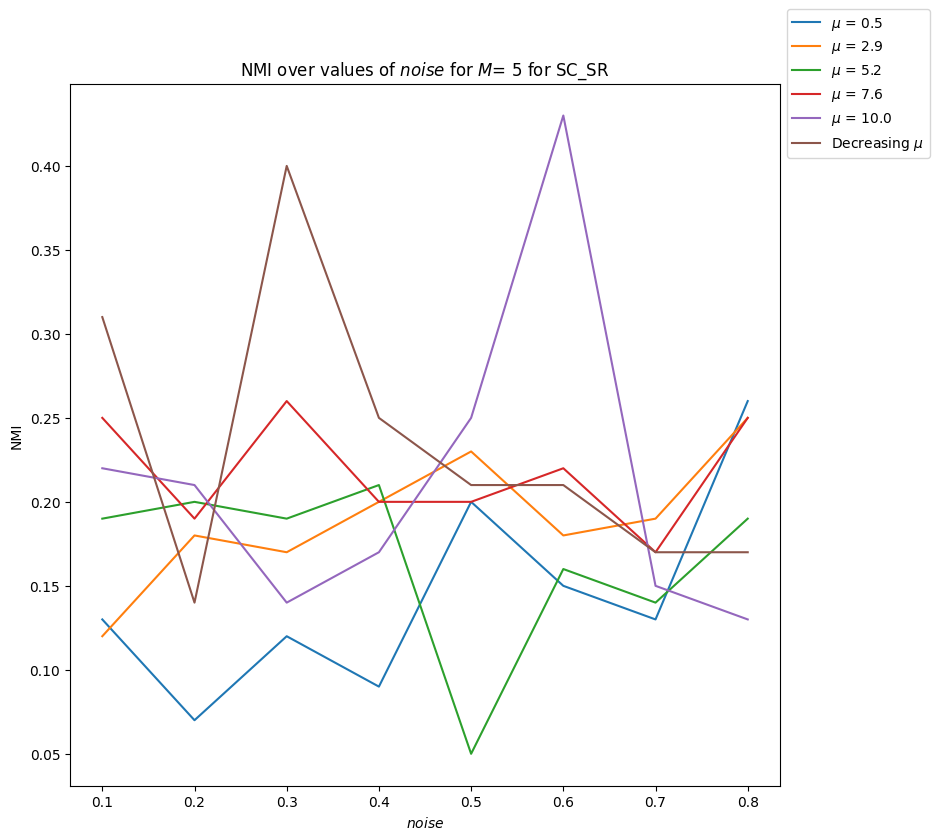

In [16]:
p = HIGH
n = 100
k = 5
M = 5

mus = np.linspace(0.5, 10, 5)
noises = np.arange(0.1, 0.9, 0.1)
all_res = {}
plt.subplots(figsize = (8, 8))
delta = 0.2

for mu in mus:
    res = []
    mu_seq_SCSR = mu*np.ones(M-1)
    for noise in noises:
        prob = np.full((k,M), p)
        prob[:,1] = noise
        prob_prime = np.full((k,k,M), p-delta)
        prob_prime[:,:,1] = np.full((k,k),noise)
        clusters_size = k*[n //k]

        matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
        predictions, run_time = SC_SR(matrix, k, true_clusters = true_clusters, mu_seq = mu_seq_SCSR)
        
        res.append(round(NMI(predictions, true_clusters), 2))

    plt.plot(noises, res, label = r'$\mu$ = {}'.format(round(mu, 1)))

res = []
for noise in noises:
    prob = np.full((k,M), p)
    prob[:,1] = noise
    prob_prime = np.full((k,k,M), p-delta)
    prob_prime[:,:,1] = np.full((k,k),noise)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    predictions, run_time = SC_SR(matrix, k, true_clusters = true_clusters, mu_seq = np.sort(np.arange(1, M))[::-1])
    
    res.append(round(NMI(predictions, true_clusters), 2))

plt.plot(noises, res, label = r'Decreasing $\mu$')
plt.title(r'NMI over values of $noise$ for $M$= {} for SC_SR'.format(M))
plt.xlabel(r'$noise$')

plt.ylabel('NMI')

plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()


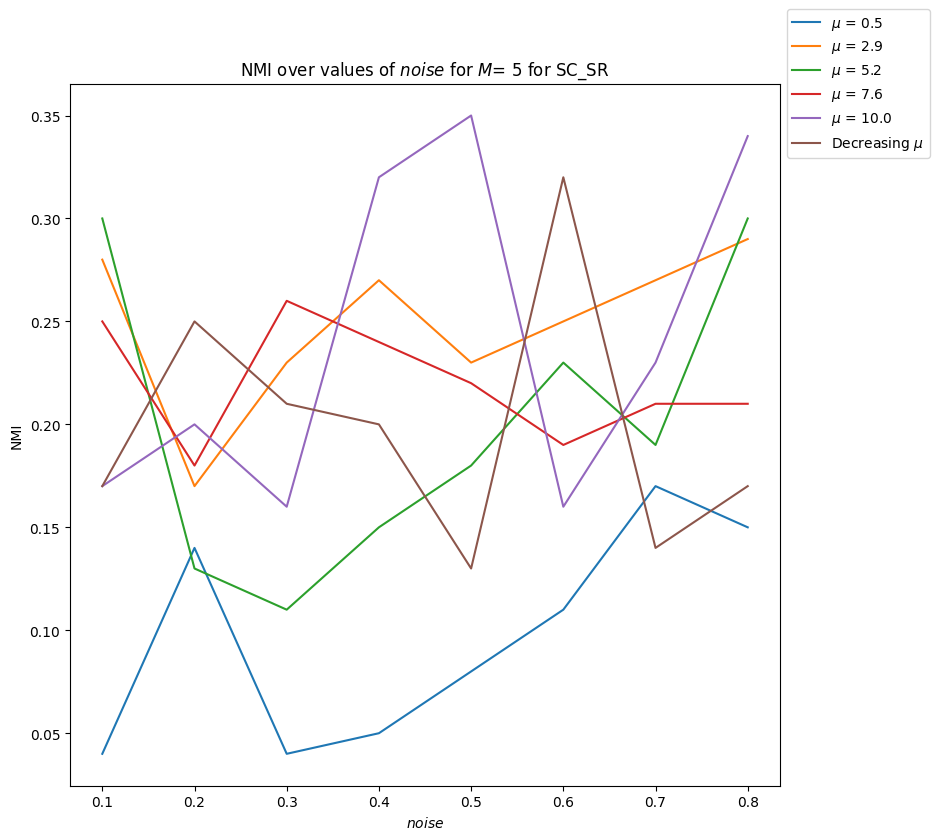

In [17]:
p = HIGH
n = 100
k = 5
M = 5

mus = np.linspace(0.5, 10, 5)
noises = np.arange(0.1, 0.9, 0.1)
all_res = {}
plt.subplots(figsize = (8, 8))
delta = 0.2

for mu in mus:
    res = []
    mu_seq_SCSR = mu*np.ones(M-1)
    for noise in noises:
        prob = np.full((k,M), p)
        prob[:,1] = noise
        prob_prime = np.full((k,k,M), p-delta)
        prob_prime[:,:,1] = np.full((k,k),noise)
        clusters_size = k*[n //k]

        matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
        predictions, run_time = ourSC_SR(matrix, k, true_clusters = true_clusters, mu_seq = mu_seq_SCSR)
        
        res.append(round(NMI(predictions, true_clusters), 2))

    plt.plot(noises, res, label = r'$\mu$ = {}'.format(round(mu, 1)))

res = []
for noise in noises:
    prob = np.full((k,M), p)
    prob[:,1] = noise
    prob_prime = np.full((k,k,M), p-delta)
    prob_prime[:,:,1] = np.full((k,k),noise)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)
    predictions, run_time = ourSC_SR(matrix, k, true_clusters = true_clusters, mu_seq = np.sort(np.arange(1, M))[::-1])
    
    res.append(round(NMI(predictions, true_clusters), 2))

plt.plot(noises, res, label = r'Decreasing $\mu$')
plt.title(r'NMI over values of $noise$ for $M$= {} for SC_SR'.format(M))
plt.xlabel(r'$noise$')

plt.ylabel('NMI')

plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()


We will keep the same value.

We now take one layer of noise, between two layers defined with the same probabilities. We try different noise (which means different probabilities of connections in there layer where every node has the same probability of connection).

M =  3 noise =  0.1
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.28  0.02  0.68     21.22
SC_SR        0.49  0.19  0.73      0.95
SC_SUM       0.44  0.22  0.65      0.00
SC_AL        0.27  0.02  0.67      0.14
CoR          0.27  0.02  0.68     47.97
ourSC_SR     0.49  0.19  0.73      1.43


M =  3 noise =  0.2
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.47  0.25  0.74     13.38
SC_SR        0.48  0.21  0.73      1.07
SC_SUM       0.50  0.26  0.72      0.00
SC_AL        0.29  0.05  0.68      0.21
CoR          0.26  0.03  0.68     36.94
ourSC_SR     0.48  0.21  0.73      0.49


M =  3 noise =  0.30000000000000004
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.33  0.07  0.69     10.80
SC_SR        0.48  0.26  0.74      0.88
SC_SUM       0.50  0.24  0.73      0.00
SC_AL        0.37  0.13  0.70      0.11
CoR          0.31  0.08  0.69     42.55


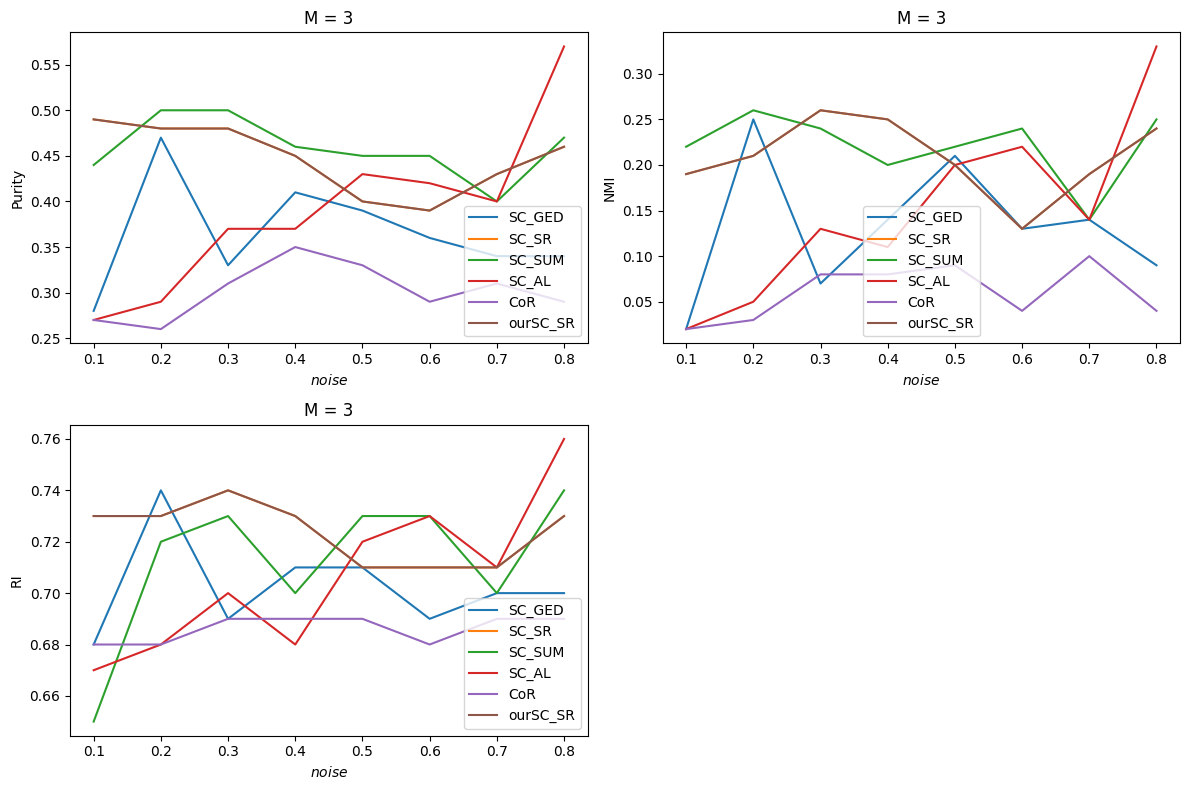

In [20]:
n = 100
p = HIGH
delta = 0.2
k = 5
M = 3


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR,ourSC_SR]
metrics = [Purity, NMI, RI]

noises = np.arange(0.1, 0.9, 0.1)
all_res = {}

for noise in noises:
    prob = np.full((k,M), p)
    prob[:,1] = noise
    prob_prime = np.full((k,k,M), p-delta)
    prob_prime[:,:,1] = np.full((k,k),noise)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)

    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)

    print("M = ", M, "noise = ", noise)
    print(results)
    print("\n")
    all_res[M, noise] = results



i = 0
plt.figure(figsize = (12, 8))
for metric in metrics:   

    plt.subplot(2, 2, i+1)
    i += 1
    for algorithm in algorithms:

        data = [all_res[M, noises[i]][metric.__name__].loc[algorithm.__name__] for i in range(noises.shape[0])]
        plt.plot(noises, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$noise$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()

What is interesting is that SC_SR and SC_GED have less variance than SC_SUM. They perform better than CoR.

Same experiment, with another $\delta$

M =  3 noise =  0.1
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.74  0.66  0.86     16.35
SC_SR        0.96  0.91  0.97      1.03
SC_SUM       0.98  0.95  0.98      0.00
SC_AL        0.50  0.31  0.76      0.15
CoR          0.80  0.69  0.89     35.92
ourSC_SR     0.96  0.91  0.97      0.41


M =  3 noise =  0.2
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.72  0.51  0.83     13.13
SC_SR        0.94  0.85  0.95      1.02
SC_SUM       0.97  0.93  0.98      0.00
SC_AL        0.58  0.34  0.76      0.19
CoR          0.66  0.50  0.81     32.31
ourSC_SR     0.94  0.85  0.95      0.48


M =  3 noise =  0.30000000000000004
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.96  0.90  0.97     14.23
SC_SR        0.96  0.90  0.97      1.34
SC_SUM       0.92  0.82  0.94      0.00
SC_AL        0.91  0.79  0.93      0.17
CoR          0.97  0.93  0.98     37.66


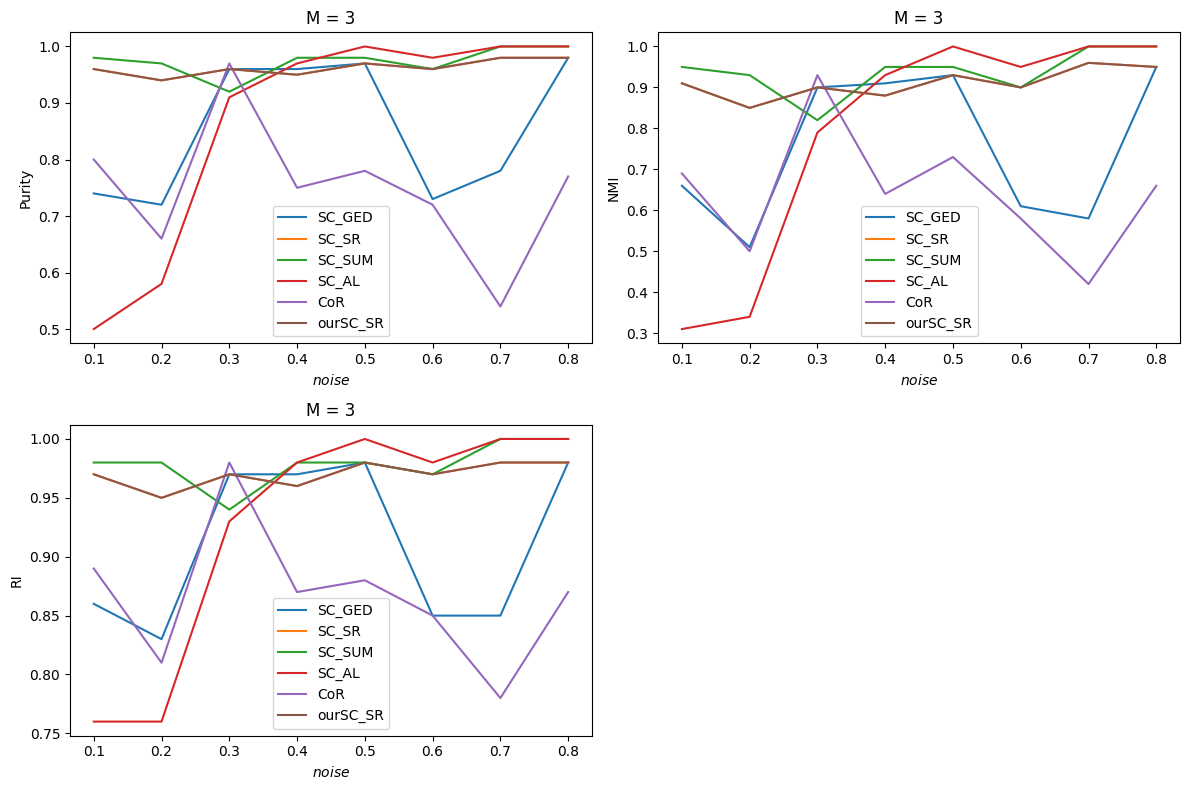

In [21]:
n = 100
p = HIGH
delta = 0.4
k = 5
M = 3


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR,ourSC_SR]
metrics = [Purity, NMI, RI]

noises = np.arange(0.1, 0.9, 0.1)
all_res = {}

for noise in noises:
    prob = np.full((k,M), p)
    prob[:,1] = noise
    prob_prime = np.full((k,k,M), p-delta)
    prob_prime[:,:,1] = np.full((k,k),noise)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)

    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)
    
    print("M = ", M, "noise = ", noise)
    print(results)
    print("\n")
    all_res[M, noise] = results



i = 0
plt.figure(figsize = (12, 8))
for metric in metrics:   

    plt.subplot(2, 2, i+1)
    i += 1
    for algorithm in algorithms:

        data = [all_res[M, noises[i]][metric.__name__].loc[algorithm.__name__] for i in range(noises.shape[0])]
        plt.plot(noises, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$noise$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()

SC_SR is very good : almost always the best, no matter the noise.

One layer of noise, between two layers with different probabilities of connection.

M =  3 noise =  0.1
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.96  0.90  0.97     11.89
SC_SR        0.97  0.93  0.98      1.01
SC_SUM       0.90  0.80  0.92      0.00
SC_AL        0.58  0.33  0.77      0.22
CoR          0.48  0.29  0.75     36.85
ourSC_SR     0.97  0.93  0.98      0.62


M =  3 noise =  0.2
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.97  0.93  0.98     15.78
SC_SR        0.99  0.98  0.99      0.80
SC_SUM       0.74  0.72  0.85      0.00
SC_AL        0.69  0.53  0.82      0.14
CoR          0.55  0.38  0.78     28.97
ourSC_SR     0.99  0.98  0.99      0.96


M =  3 noise =  0.30000000000000004
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.77  0.65  0.87     13.42
SC_SR        0.95  0.89  0.96      1.13
SC_SUM       0.53  0.33  0.73      0.00
SC_AL        0.67  0.51  0.82      0.19
CoR          0.52  0.35  0.76     29.53


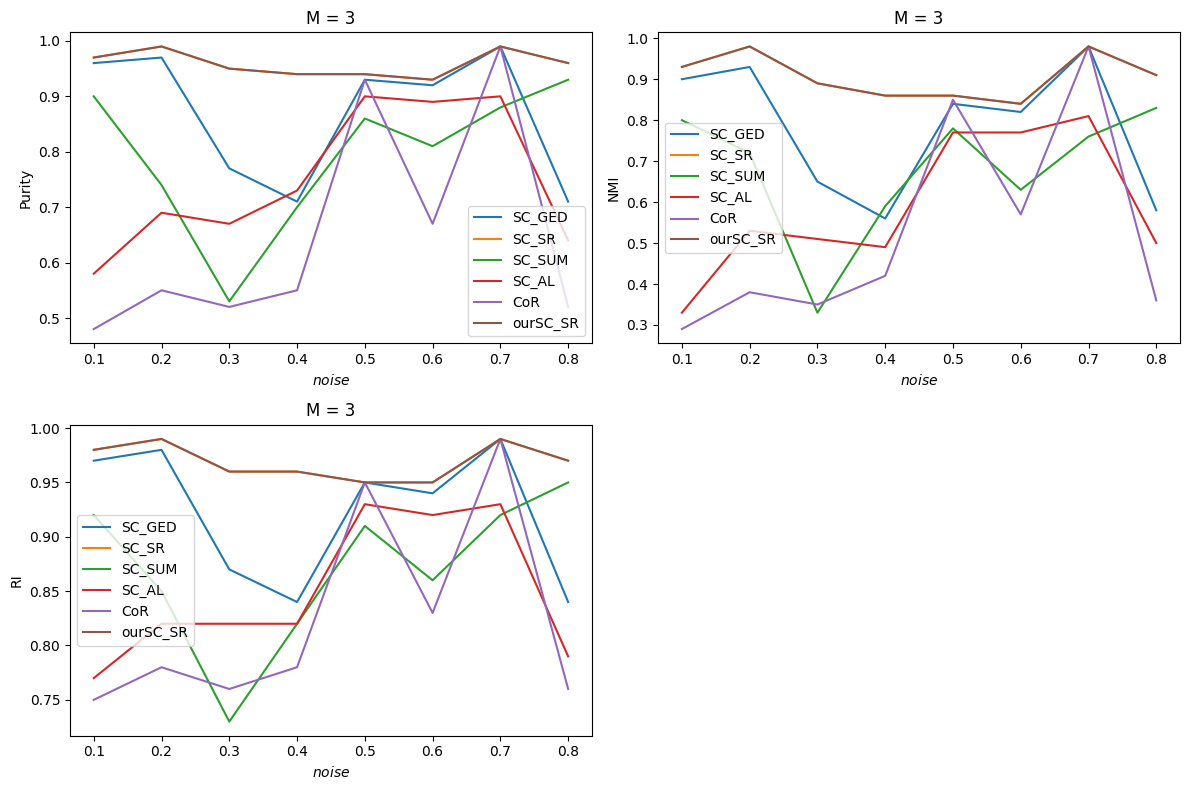

In [23]:
n = 100
p = HIGH
delta = 0.4
k = 5
M = 3


algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR, ourSC_SR]
metrics = [Purity, NMI, RI]

noises = np.arange(0.1, 0.9, 0.1)
all_res = {}

for noise in noises:
    prob = np.full((k,M), p)
    prob[:,1] = noise
    prob[:,2] = 0.3
    prob_prime = np.full((k,k,M), p-delta)
    prob_prime[:,:,1] = np.full((k,k),noise)
    prob_prime[:,:,2] = np.full((k,k),0.1)
    clusters_size = k*[n //k]


    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)

    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)
    
    print("M = ", M, "noise = ", noise)
    print(results)
    print("\n")
    all_res[M, noise] = results



i = 0
plt.figure(figsize = (12, 8))
for metric in metrics:   

    plt.subplot(2, 2, i+1)
    i += 1
    for algorithm in algorithms:

        data = [all_res[M, noises[i]][metric.__name__].loc[algorithm.__name__] for i in range(noises.shape[0])]
        plt.plot(noises, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$noise$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()

SC_SR is from far away the best code. This is logical, with this setting, we use all its capacity. All the methods based on an average have less good performance. This is quite logical because they are much more affected by the noisy layers.

Now, we try to modify the number of noisy layers.

In [34]:
n = 100
p = HIGH
delta = 0.4
k = 5
M = 5

noise = 0.4

algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR,ourSC_SR]
metrics = [Purity, NMI, RI]

M_list = np.array([i for i in range(3,10)])
all_res = {}

for M in M_list:
    prob = np.full((k,M), p)
    prob[:,1] = noise
    prob[:,2] = 0.3
    prob[:,3:] = noise

    prob_prime = np.full((k,k,M), p-delta)
    prob_prime[:,:,1] = np.full((k,k),noise)
    prob_prime[:,:,3:] = np.full((k,k,M-3),noise)
    prob_prime[:,:,2] = np.full((k,k),0.1)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)


    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)

    print("M = ", M, "noise = ", noise)
    print(results)
    print("\n")
    all_res[M] = results

M =  3 noise =  0.4
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.72  0.56  0.84     18.18
SC_SR        0.97  0.93  0.98      1.32
SC_SUM       0.88  0.78  0.91      0.00
SC_AL        0.95  0.88  0.96      0.19
CoR          0.73  0.61  0.85     44.01
ourSC_SR     0.97  0.93  0.98      0.73


M =  4 noise =  0.4
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.91  0.78  0.93     25.95
SC_SR        0.58  0.38  0.77      1.15
SC_SUM       0.64  0.39  0.78      0.00
SC_AL        0.74  0.52  0.83      0.13
CoR          0.52  0.42  0.78     44.38
ourSC_SR     0.58  0.38  0.77      0.61


M =  5 noise =  0.4
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.97  0.93  0.98     22.80
SC_SR        0.96  0.90  0.97      3.01
SC_SUM       0.54  0.33  0.75      0.00
SC_AL        0.61  0.49  0.80      0.45
CoR          0.75  0.68  0.87     36.68
ourSC_SR     0.9

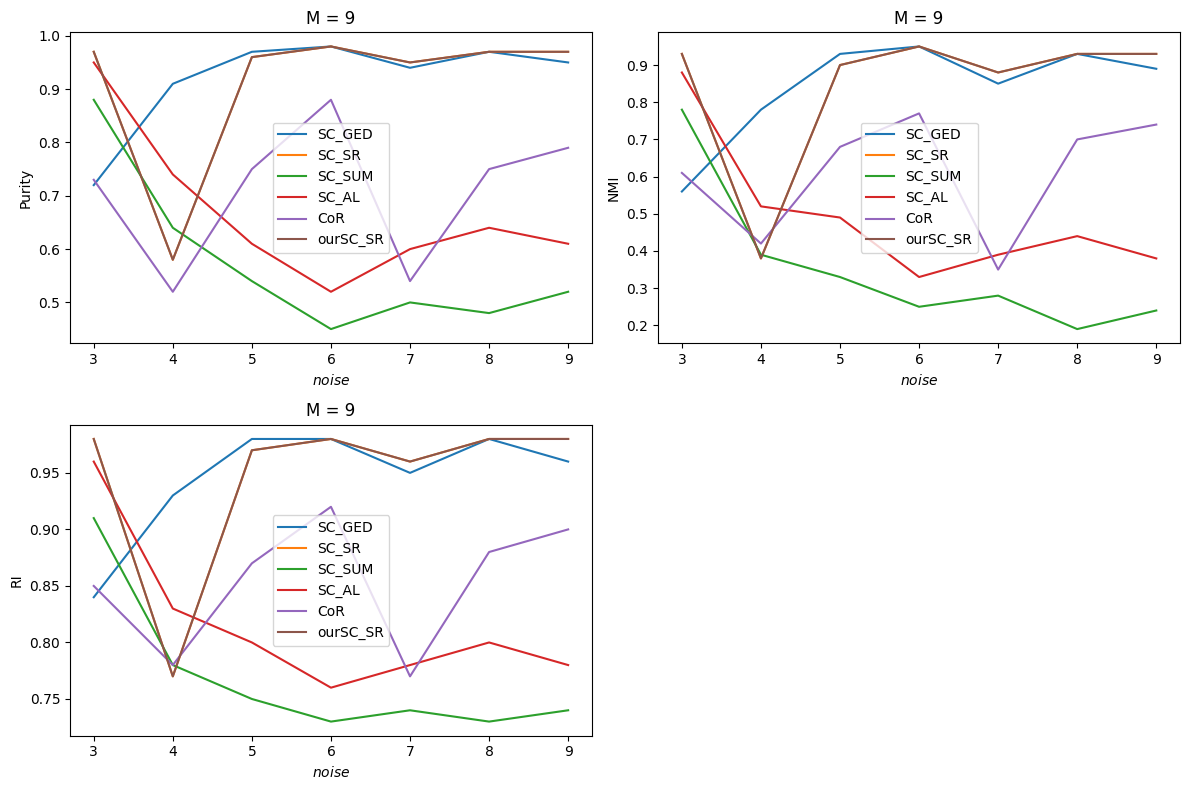

In [35]:
i = 0    
plt.figure(figsize = (12, 8))

for metric in metrics:   
    plt.subplot(2, 2, i+1)
    i+=1
    for algorithm in algorithms:

        data = [all_res[M_list[i]][metric.__name__].loc[algorithm.__name__] for i in range(M_list.shape[0])]
        plt.plot(M_list, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$noise$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()

We have something quite abnormal in $4$, but otherwise, SC_SR and SC_GED are much more efficient. Above all, they are not affected by the noise, while the others are.

To avoid the abnormality, we can change the arrangement of the layers with the following example

In [37]:
n = 100
p = HIGH
delta = 0.4
k = 5
M = 5

noise = 0.4

algorithms = [SC_GED, SC_SR, SC_SUM, SC_AL, CoR,ourSC_SR]
metrics = [Purity, NMI, RI]

M_list = np.array([i for i in range(3,10)])
all_res = {}

for M in M_list:
    prob = np.full((k,M), p)
    prob[:,-1] = 0.3
    prob[:,1:M-1] = noise

    prob_prime = np.full((k,k,M), p-delta)
    prob_prime[:,:,1:M-1] = np.full((k,k,M-2),noise)
    prob_prime[:,:,-1] = np.full((k,k),0.1)
    clusters_size = k*[n //k]

    matrix,true_clusters = graphCreation(n,M,k,clusters_size,prob,prob_prime, plot_adj = False)


    mu_seq_SCSR = mu*np.ones(M-1)
    results = runResults(matrix, true_clusters, k, algorithms, metrics, mu_seq_SCSR = mu_seq_SCSR)

    print("M = ", M, "noise = ", noise)
    print(results)
    print("\n")
    all_res[M] = results

M =  3 noise =  0.4
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.98  0.96  0.98     20.97
SC_SR        0.98  0.96  0.98      1.55
SC_SUM       0.77  0.72  0.88      0.00
SC_AL        0.90  0.76  0.93      0.17
CoR          0.79  0.71  0.89     46.20
ourSC_SR     0.98  0.96  0.98      0.74


M =  4 noise =  0.4
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.92  0.82  0.94     32.91
SC_SR        0.89  0.79  0.92      5.23
SC_SUM       0.81  0.61  0.87      0.00
SC_AL        0.79  0.59  0.85      0.82
CoR          0.75  0.60  0.86     45.52
ourSC_SR     0.89  0.79  0.92      0.82


M =  5 noise =  0.4
           Purity   NMI    RI  Run Time
Algorithm                              
SC_GED       0.92  0.81  0.94     27.19
SC_SR        0.93  0.84  0.95      3.75
SC_SUM       0.56  0.35  0.75      0.00
SC_AL        0.88  0.72  0.91      0.14
CoR          0.73  0.58  0.84     41.09
ourSC_SR     0.9

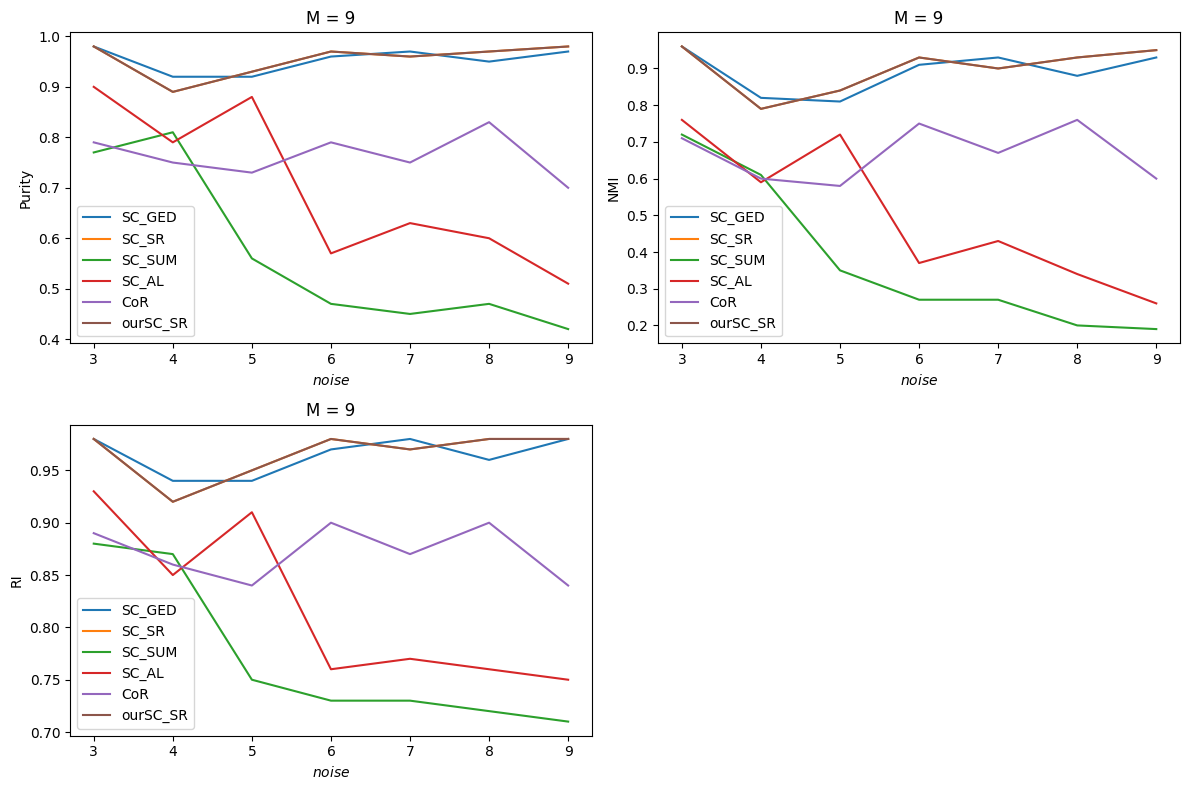

In [38]:
i = 0    
plt.figure(figsize = (12, 8))

for metric in metrics:   
    plt.subplot(2, 2, i+1)
    i+=1
    for algorithm in algorithms:

        data = [all_res[M_list[i]][metric.__name__].loc[algorithm.__name__] for i in range(M_list.shape[0])]
        plt.plot(M_list, data, label = algorithm.__name__)

    plt.title("M = " + str(M))
    plt.xlabel(r"$noise$")
    plt.ylabel(metric.__name__)
    plt.legend()

plt.tight_layout()
plt.show()